In [1]:
%autosave 0

Autosave disabled


### Kaggle - Web Traffic Time Series Forecasting

## Model 10 - Modified CNN with Fibonacci

### v4 The Model Beta

by Louis Yang

Use Fibonacci series median as the center of each data.

According to the center, split data into groups and train individual neural network (model) in each group.

The grouping split are log10(fib_med + 1) < (1.0 , 2.0, 4.0, rest) There are total 4 groups.

The first 1 groups use original Fibonacci median as prediction since it is difficult to learn. The rest groups use the trained CNN as prediction.

The neural network structure is: 

    1 Conv1D(120) with filter size 3 > Average pooling(2) > FC(120) > FC(120) > FC(63, linear).

Then do ensemble learning: Evaluate the same model 5 times and take the ensemble median.

v0 Feed second input (median and stdev) to the neural network after the CNN part.

Test on stage 1 data.

Original model: 'model_10_Modified_CNN_0_median_stdev'

In [2]:
model_name = 'model_10_Modified_CNN_4_The_Model_1_stage_1_predict'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect
from tools import *

## Input

In [4]:
train_file = 'train_1.csv'

In [5]:
key_file = 'key_1.csv'

In [6]:
input_df = pd.read_csv('../data/' + train_file, nrows=1)

In [7]:
input_df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,32,63,15,26,14,20,22,19,18,20


In [8]:
input_df_dates = input_df.columns[1:]; input_df_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=550)

In [9]:
visits_dtype = {d: np.float32 for d in input_df_dates}

In [10]:
print('%%% Reading data '+ train_file + ' ... ', end = '', flush = True)
input_df = pd.read_csv('../data/' + train_file, engine='c', dtype=visits_dtype)
print('done!')

%%% Reading data train_1.csv ... done!


In [11]:
input_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [12]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float32(550), object(1)
memory usage: 305.5+ MB


## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [13]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [14]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

In [15]:
test_length = 0  # for predicting
#test_length = y_length  # for self testing

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [16]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [17]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2015-11-01', '2016-01-02')

In [18]:
daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [19]:
# X for output set
if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

In [20]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2016-10-30', '2016-12-31')

In [21]:
daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [22]:
weekday(X_input_first_day), weekday(X_output_first_day)

(6, 6)

Should be the same

#### Y

In [23]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [24]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2016-01-03', '2016-03-05')

In [25]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-62)

In [26]:
if test_length == 0:  # Prefetch the key_file
    output_df = pd.read_csv('../data/' + key_file, nrows=64)
    output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
    output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
    #output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
    #test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
    print(output_df.head())

                                           Page            Id        date
0  !vote_en.wikipedia.org_all-access_all-agents  bf4edcf969af  2017-01-01
1  !vote_en.wikipedia.org_all-access_all-agents  929ed2bf52b9  2017-01-02
2  !vote_en.wikipedia.org_all-access_all-agents  ff29d0f51d5c  2017-01-03
3  !vote_en.wikipedia.org_all-access_all-agents  e98873359be6  2017-01-04
4  !vote_en.wikipedia.org_all-access_all-agents  fa012434263a  2017-01-05


In [27]:
if test_length == 0:
    output_df_dates_all = output_df.date.values.astype('datetime64[D]')
    output_df_first_day = str(output_df_dates_all.min())
    output_df_final_day = str(output_df_dates_all.max())
    print(output_df_first_day, output_df_final_day)

2017-01-01 2017-03-01


In [28]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-01-01'  ## Make sure it is correct when predicting !!!!!!!
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [29]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2017-01-01', '2017-03-04')

In [30]:
daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

datetime.timedelta(-62)

In [31]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(6, 6)

Should be the same

## Fibonacci

#### Window Sizes

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [32]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]
fib_length = max(windows)#; fib_length

#### Data selection

In this testing code, we did not include the last y_length days since in the real predicting stage, we don't know their visits.

In [33]:
if test_length:
    fib_output_dates = input_df_dates[-fib_length-test_length:-test_length]
else:
    fib_output_dates = input_df_dates[-fib_length:]
fib_input_dates = input_df_dates[-fib_length-test_length-364:-test_length-364]
fib_input_dates, fib_output_dates

(Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
        '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
        ...
        '2015-12-24', '2015-12-25', '2015-12-26', '2015-12-27', '2015-12-28',
        '2015-12-29', '2015-12-30', '2015-12-31', '2016-01-01', '2016-01-02'],
       dtype='object', length=186),
 Index(['2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11',
        '2016-02-12', '2016-02-13', '2016-02-14', '2016-02-15', '2016-02-16',
        ...
        '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
        '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
       dtype='object', length=329))

In [34]:
weekday(fib_input_dates[0]), weekday(fib_output_dates[0])

(2, 6)

In [35]:
fib_output_data = input_df[fib_output_dates].values; #fib_output_data

In [36]:
fib_input_data = input_df[fib_input_dates].values; #fib_input_data

#### Fibonacci median in each window

In [37]:
fib_input_median_list = np.array([np.nanmedian(fib_input_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [38]:
fib_output_median_list = np.array([np.nanmedian(fib_output_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


fib_input_median_list.T.shape

fib_output_median_na = np.nanmedian(fib_output_median_list.T, axis=-1)

fib_output_median_na

In [39]:
fib_input_median = np.nan_to_num(np.nanmedian(fib_input_median_list.T, axis=-1)); fib_input_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [40]:
fib_output_median = np.nan_to_num(np.nanmedian(fib_output_median_list.T, axis=-1)); fib_output_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

fib_input_median

fib_output_median

In [41]:
del fib_output_data
del fib_input_data
del fib_output_median_list
del fib_input_median_list
gc.collect()

359

We will use this as the center and part of the result

In [42]:
Y_input_fib = fib_input_median.reshape(-1,1)
Y_output_fib = fib_output_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input and Output data

In [43]:
X_input_raw = input_df[X_input_dates].values
Y_input_raw = input_df[Y_input_dates].values
X_output_raw = input_df[X_output_dates].values
if test_length:
    Y_output_raw = input_df[Y_output_dates].values

##### Convert nan to number 0.

In [44]:
X_input_num = np.nan_to_num(X_input_raw)
Y_input_num = np.nan_to_num(Y_input_raw)
X_output_num = np.nan_to_num(X_output_raw)
if test_length:
    Y_output_num = np.nan_to_num(Y_output_raw)

## Transform Data

### Log

In [45]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [46]:
X_input_raw_log = log(X_input_raw)  # Contain nan
Y_input_raw_log = log(Y_input_raw)
X_output_raw_log = log(X_output_raw)
if test_length:
    Y_output_raw_log = log(Y_output_raw)

In [47]:
X_input_log = log(X_input_num)  # Do not contain nan
Y_input_log = log(Y_input_num)
X_output_log = log(X_output_num)
if test_length:
    Y_output_log = log(Y_output_num)

In [48]:
X_input_log

array([[ 1.39794004,  0.84509802,  0.84509802, ...,  1.27875364,
         1.        ,  1.23044896],
       [ 1.07918119,  1.17609131,  1.17609131, ...,  1.        ,
         0.90309   ,  1.20412004],
       [ 0.84509802,  0.47712126,  0.77815127, ...,  0.47712126,
         0.47712126,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

Z_input_data_log = log(Z_input_data_num)

##### Check Log transformation

In [49]:
print(X_input_log.shape, Y_input_log.shape, X_output_log.shape)
if test_length: print(Y_output_log.shape)

(145063, 63) (145063, 63) (145063, 63)


In [50]:
arr_info((X_input_log, Y_input_log, X_output_log))
if test_length: arr_info([Y_output_log])

shape, min, max, median, stdev
(145063, 63) 0.0 7.32973 1.94939 1.11236
(145063, 63) 0.0 7.33406 2.06819 1.10754
(145063, 63) 0.0 7.45244 2.15836 1.00455


In [51]:
#Check inverse log transformation
X_input_log_tt = unlog(X_input_log)
X_input_log_tt_dif = X_input_log_tt - X_input_num
X_input_log_tt_dif.min(), X_input_log_tt_dif.max(), np.median(X_input_log_tt_dif), np.std(X_input_log_tt_dif)

(-12.0, 10.0, 0.0, 0.019053582)

In [52]:
X_output_log_tt = unlog(X_output_log)
X_output_log_tt_dif = X_output_log_tt - X_output_num
X_output_log_tt_dif.min(), X_output_log_tt_dif.max(), np.median(X_output_log_tt_dif), np.std(X_output_log_tt_dif)

(-12.0, 12.0, 0.0, 0.027352171)

In [53]:
Y_input_log_tt = unlog(Y_input_log)
Y_input_log_tt_dif = Y_input_log_tt - Y_input_num
Y_input_log_tt_dif.min(), Y_input_log_tt_dif.max(), np.median(Y_input_log_tt_dif), np.std(Y_input_log_tt_dif)

(-12.0, 10.0, 0.0, 0.019966528)

In [54]:
if test_length:
    Y_output_log_tt = unlog(Y_output_log)
    Y_output_log_tt_dif = Y_output_log_tt - Y_output_num
    print(Y_output_log_tt_dif.min(), Y_output_log_tt_dif.max(), np.median(Y_output_log_tt_dif), np.std(Y_output_log_tt_dif))

In [55]:
del X_input_log_tt; del X_input_log_tt_dif
del X_output_log_tt; del X_output_log_tt_dif
del Y_input_log_tt; del Y_input_log_tt_dif
if test_length: 
    del Y_output_log_tt; del Y_output_log_tt_dif
gc.collect()

278

There is some error (~10) due to float32 when unlog (exp) it. However, for those cases, the original number is about 10^7 so the relative error is still very small.

### Normalization (Center and Scale)

#### Center

In [56]:
output_center = log(fib_output_median).reshape(-1,1) # Fib. median as the center
#input_center = log(fib_input_median).reshape(-1,1)
input_center = output_center  # using output_center instead

In [57]:
X_input_center = input_center
Y_input_center = input_center
X_output_center = output_center
Y_output_center = output_center

In [58]:
output_center.shape

(145063, 1)

In [59]:
input_center, output_center

(array([[ 1.28443074],
        [ 1.35218251],
        [ 0.69897002],
        ..., 
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]], dtype=float32), array([[ 1.28443074],
        [ 1.35218251],
        [ 0.69897002],
        ..., 
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]], dtype=float32))

plt.scatter(X_input_center.reshape(-1),Y_input_center.reshape(-1))
plt.show()

Z_input_center = np.median(Z_input_data_log, axis=-1).reshape(-1,1)

Z_input_center.shape

#Use Regular Median as the Center for X
#Choice 1: Not including nan
X_input_center = np.nan_to_num(np.nanmedian(X_input_log, axis=-1)).reshape(-1,1)
X_output_center = np.nan_to_num(np.nanmedian(X_output_log, axis=-1)).reshape(-1,1)

#Choice 2: Including nan
#X_input_center = np.median(np.nan_to_num(X_input_log), axis=-1).reshape(-1,1)
#X_output_center = np.median(np.nan_to_num(X_output_log), axis=-1).reshape(-1,1)

Y_input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
Y_input_center  # remember sample-wised center

Y_output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
Y_output_center  # remember sample-wised center

#### Choice of default scale

In [60]:
default_input_scale = np.nanmedian(np.nanstd(X_input_raw_log, axis=-1))  # Do not include nan
default_input_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.18326113

In [61]:
default_output_scale = np.nanmedian(np.nanstd(X_output_raw_log, axis=-1))  # Do not include nan
default_output_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.18844549

In [62]:
default_scale = np.mean([default_input_scale, default_output_scale]); default_scale

0.1858533

#### Scale

In [63]:
#Choice 1: Treat nan as 0
input_scale = np.std(X_input_log, axis=-1).reshape(-1,1)
output_scale = np.std(X_output_log, axis=-1).reshape(-1,1)

#Choice 2: Not including nan
#input_scale = np.nan_to_num(np.nanstd(X_input_raw_log, axis=-1)).reshape(-1,1)
#output_scale = np.nan_to_num(np.nanstd(X_output_raw_log, axis=-1)).reshape(-1,1)

input_scale[input_scale == 0.0] = default_scale  # Prevent divid by zero 
output_scale[output_scale == 0.0] = default_scale  # Prevent divid by zero 

In [64]:
X_input_scale = input_scale
Y_input_scale = input_scale
X_output_scale = output_scale
Y_output_scale = output_scale

In [65]:
input_scale

array([[ 0.28698003],
       [ 0.24215421],
       [ 0.19345188],
       ..., 
       [ 0.1858533 ],
       [ 0.1858533 ],
       [ 0.1858533 ]], dtype=float32)

In [66]:
output_scale

array([[ 0.25058442],
       [ 0.27659199],
       [ 0.30125919],
       ..., 
       [ 0.1858533 ],
       [ 0.1858533 ],
       [ 0.1858533 ]], dtype=float32)

Z_input_scale = np.std(Z_input_data_log, axis=-1).reshape(-1,1)
Z_input_scale[Z_input_scale == 0.0] = default_input_scale  # Prevent divid by zero
Z_input_scale  # remember sample-wised scale

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [67]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [68]:
# Normalize after nan->0
X_input = transform(X_input_log, X_input_center, X_input_scale)
X_output = transform(X_output_log, X_output_center, X_output_scale)
Y_input = transform(Y_input_log, Y_input_center, Y_input_scale)
if test_length:
    Y_output = transform(Y_output_log, Y_output_center, Y_output_scale)    

# Another choice: Normalize before nan->0
#X_input = np.nan_to_num(transform(X_input_raw_log, X_input_center, input_scale))
#X_output = np.nan_to_num(transform(X_output_raw_log, X_output_center, output_scale))
#Y_input = np.nan_to_num(transform(Y_input_raw_log, Y_input_center, input_scale))
#if test_length:
#    Y_output = np.nan_to_num(transform(Y_output_raw_log, Y_output_center, output_scale))

Note:

* If we take nan_to_num before transform, we make sure the nan got transformed into 0 but not the center.
* If we take nan_to_num after transform, nan trun into the center but not 0 of the original data.

examine(Y_input)

input_data_norm = transform(input_data_log, Y_input_center, input_scale)
output_data_norm = transform(output_data_log, Y_output_center, output_scale)

Z_input = transform(Z_input_data_log, Z_input_center, Z_input_scale)

##### Check median and stdev transformations

In [69]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

check_nan(X_input)  # Check if there is any nan in the input_data

#Check inverse scale transformation
X_input_unnorm = untransform(X_input, X_input_center, X_input_scale)
X_input_unnorm_dif = X_input_unnorm - X_input_log
X_input_unnorm_dif.min(), X_input_unnorm_dif.max()

#Check inverse scale transformation
Y_input_unnorm = untransform(Y_input, Y_input_center, Y_input_scale)
Y_input_unnorm_dif = Y_input_unnorm - Y_input_log
Y_input_unnorm_dif.min(), Y_input_unnorm_dif.max()

#Check inverse scale transformation
X_output_unnorm = untransform(X_output, X_output_center, X_output_scale)
X_output_unnorm_dif = X_output_unnorm - X_output_log
X_output_unnorm_dif.min(), X_output_unnorm_dif.max()

#Check inverse scale transformation
Y_output_unnorm = untransform(Y_output, Y_output_center, Y_output_scale)
Y_output_unnorm_dif = Y_output_unnorm - Y_output_log
Y_output_unnorm_dif.min(), Y_output_unnorm_dif.max()

del X_input_unnorm; del X_input_unnorm_dif
del Y_input_unnorm; del Y_input_unnorm_dif
del X_output_unnorm; del X_output_unnorm_dif
del Y_output_unnorm; del Y_output_unnorm_dif
gc.collect()

## Center (Median) and Scale (Stdev) Investigation

### Center

plt.hist(Y_input_center, bins=40, alpha=0.5, label='input')
plt.hist(Y_output_center, bins=40, alpha=0.5, label='output')
plt.hist(X_input_center, bins=40, alpha=0.5, label='input')
plt.hist(X_output_center, bins=40, alpha=0.5, label='output')
#plt.hist(Z_input_center, bins=40, alpha=0.5, label='Z_input')
plt.legend()
plt.show()

plt.hist(Y_input_center, bins=40, alpha=0.7, label='input')
plt.hist(Y_output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Scale

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
#plt.hist(Z_input_scale, bins=40, alpha=0.7, label='Z_input')
plt.legend()
plt.show()

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [70]:
def group_index(logx):
    if logx < 1.0: return 0
    elif logx < 2.0: return 1
    elif logx < 4.0: return 2
    else: return 3
group_index_v = np.vectorize(group_index)
gp_list = list(range(4)); gp_list

[0, 1, 2, 3]

def group_index(median, stdev):
    if median < 1.0: return 0
    elif median < 2.0: 
        if stdev < 1.7: return 1
        else: return 2
    elif median < 4.0: 
        if stdev < 1.7: return 3
        else: return 4
    else: return 5
#group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

input_gp = np.array([group_index(center, scale) for center, scale in zip(Y_input_center, input_scale)]).reshape(-1)
output_gp = np.array([group_index(center, scale) for center, scale in zip(Y_output_center, output_scale)]).reshape(-1)

In [71]:
# Choice 1: Group using X center
input_gp = group_index_v(X_input_center).reshape(-1)
output_gp = group_index_v(X_output_center).reshape(-1)

# Choice 2: Group using Y center (Fib Median)
#input_gp = group_index_v(Y_input_center).reshape(-1)
#output_gp = group_index_v(Y_output_center).reshape(-1)

In [72]:
input_gp, output_gp

(array([1, 1, 0, ..., 0, 0, 0]), array([1, 1, 0, ..., 0, 0, 0]))

In [73]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
gp_input_counts

[24379, 41343, 78354, 987]

In [74]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
gp_output_counts

[24379, 41343, 78354, 987]

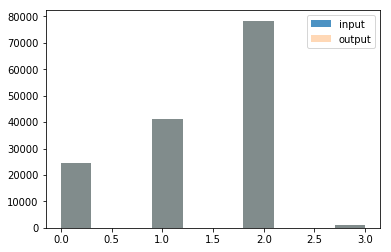

In [75]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

#### Original data

In [76]:
X_input_ori = X_input_num  # Do not contain nan
Y_input_ori = Y_input_num
X_output_ori = X_output_num
if test_length:
    Y_output_ori = Y_output_num

In [77]:
if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

shape, min, max, median, stdev
(145063, 63) -97.6165 188.128 -0.362991 4.10232
(145063, 63) -286.67 231.915 0.0 4.21988
(145063, 63) -110.338 8.00102 0.0 1.2819
(145063, 63) 0.0 2.13664e+07 88.0 62373.1
(145063, 63) 0.0 2.15803e+07 116.0 63447.6
(145063, 63) 0.0 2.83429e+07 143.0 81329.6


arr_info((Z_input,))

#### Min and max cases examination

np.argmin(Y_output, axis=0)

Y_output[8604]

Y_output_ori[8604]

fib_output_median[8604]

log(Y_output_ori[8604])

log(fib_output_median[8604])

np.std(log(Y_output_ori[8604]))

np.std(log(X_output_ori[8604]))

output_scale[8604]

#### Check if the inverse transformation is correct

#Undo transformation
X_input_tt = unlog(untransform(X_input, X_input_center, X_input_scale))

X_input_tt_diff = X_input_tt - X_input_ori
X_input_tt_diff.min(), X_input_tt_diff.max()

del X_input_tt_diff; del X_input_tt

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [78]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

Z_input_list = [Z_input[input_gp == gp] for gp in gp_list]
Z_output_list = [Z_output[output_gp == gp] for gp in gp_list]

## Additional input for the neural network

#Split center into group
Y_input_center_list = [Y_input_center[input_gp == gp] for gp in gp_list]
Y_output_center_list = [Y_output_center[output_gp == gp] for gp in gp_list]

#Split scale into group
input_scale_list = [input_scale[input_gp == gp] for gp in gp_list]
output_scale_list = [output_scale[output_gp == gp] for gp in gp_list]

input_scale_list[0].shape

In [79]:
A_input = np.concatenate((Y_input_center, input_scale), axis=1)
A_output = np.concatenate((Y_output_center, output_scale), axis=1); A_input.shape, A_output.shape

((145063, 2), (145063, 2))

In [80]:
A_input_list = [A_input[input_gp == gp] for gp in gp_list]
A_output_list = [A_output[output_gp == gp] for gp in gp_list]

In [81]:
a_length = len(A_input[0]); a_length

2

## Neural Network?

In [82]:
import keras

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [83]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(), None))
    return 200. * K.mean(diff, axis=-1)

In [84]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), np.float32(1e-07), None))
    return np.float32(200.) * np.nanmean(diff, axis=axis)

smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

In [85]:
# Benchmark SMAPE on the transformed data
smape(Y_input,X_input), smape(Y_input, X_output), smape(Y_input,Y_input)

(109.8614, 148.24416, 0.0)

In [86]:
# Benchmark SMAPE on the original data
smape(Y_input_raw,X_input_ori), smape(Y_input_ori,X_input_ori)

(58.879555, 54.623848)

In [87]:
if test_length: print(smape(Y_output_raw, X_output_ori), smape(Y_output, X_output))

In [88]:
print(smape(Y_input_raw, Y_input_fib))
if test_length: print(smape(Y_output_raw, Y_output_fib))

47.0307


Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [89]:
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

In [90]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import concatenate

In [91]:
n_ens = 5
ens_list = list(range(n_ens))

In [92]:
#runbelow
models_ens = []
for run in ens_list:
    print('Run', run, end=': ')
    models = []
    for gp in gp_list:
        print('Group-', gp, sep='', end=' ')
        layer_0 = Input(shape=(x_length,), name='x_input')
        layer_t = Reshape((-1, 1))(layer_0)
        layer_t = Conv1D(120, kernel_size=3, activation='relu')(layer_t)
        layer_t = AveragePooling1D(pool_size=2)(layer_t)
        layer_cnn_x = Flatten()(layer_t)
        
        layer_a = Input(shape=(a_length,), name='a_input')
        
        #layer_z = Input(shape=(y_length,), name='z_input')
        #layer_t = Reshape((-1, 1))(layer_0)
        #layer_t = Conv1D(20, kernel_size=3, activation='relu')(layer_t)
        #layer_t = AveragePooling1D(pool_size=2)(layer_t)
        #layer_cnn_z = Flatten()(layer_t)
                
        layer_t = concatenate([layer_cnn_x, layer_a])#, layer_cnn_z])
        
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.25)(layer_t)
        layer_t = Dense(120, activation='relu')(layer_t)
        layer_t = Dropout(0.5)(layer_t)
        layer_f = Dense(y_length)(layer_t)
        
        model = Model(inputs=[layer_0, layer_a], outputs=layer_f)
        #model = Model(inputs=[layer_0, layer_a, layer_z], outputs=layer_f)
        model.compile(optimizer='adam',
                      loss='mean_absolute_error', metrics=[k_smape])
        #model.summary()
        models.append(model)
    models_ens.append(models)
    print('')

Run 0: Group-0 Group-1 Group-2 Group-3 
Run 1: Group-0 Group-1 Group-2 Group-3 
Run 2: Group-0 Group-1 Group-2 Group-3 
Run 3: Group-0 Group-1 Group-2 Group-3 
Run 4: Group-0 Group-1 Group-2 Group-3 


In [93]:
models_ens[-1][-1].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
x_input (InputLayer)             (None, 63)            0                                            
____________________________________________________________________________________________________
reshape_20 (Reshape)             (None, 63, 1)         0           x_input[0][0]                    
____________________________________________________________________________________________________
conv1d_20 (Conv1D)               (None, 61, 120)       480         reshape_20[0][0]                 
____________________________________________________________________________________________________
average_pooling1d_20 (AveragePoo (None, 30, 120)       0           conv1d_20[0][0]                  
___________________________________________________________________________________________

In [94]:
np.array(models_ens).shape

(5, 4)

In [95]:
len(gp_list)

4

In [96]:
epochs_list = [1,40,40,60]  # change to smaller epochs later (1,1,20,40,60,80)

In [97]:
%%time
hists_ens = []
for run, models in zip(ens_list, models_ens):
    print('=== Run:', run+1, '/', len(ens_list), '===')
    hists = []
    for (gp, model, X_in, Y_in, epochs, A_in) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list, A_input_list):
        print('--- Group:', gp+1, '/', len(gp_list), '---')
        hist = model.fit([X_in, A_in], Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.1, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ens.append(hists)

=== Run: 1 / 5 ===
--- Group: 1 / 4 ---
Train on 21941 samples, validate on 2438 samples
Epoch 1/1
5s - loss: 1.0761 - k_smape: 143.7072 - val_loss: 0.9110 - val_k_smape: 133.7385
--- Group: 2 / 4 ---
Train on 37208 samples, validate on 4135 samples
Epoch 1/40
7s - loss: 1.2880 - k_smape: 122.3744 - val_loss: 1.0761 - val_k_smape: 124.7623
Epoch 2/40
6s - loss: 1.1855 - k_smape: 113.0242 - val_loss: 1.0426 - val_k_smape: 119.2731
Epoch 3/40
6s - loss: 1.1604 - k_smape: 111.0927 - val_loss: 1.1146 - val_k_smape: 123.5686
Epoch 4/40
6s - loss: 1.1609 - k_smape: 110.4752 - val_loss: 1.0556 - val_k_smape: 120.3246
Epoch 5/40
6s - loss: 1.1447 - k_smape: 109.7628 - val_loss: 1.0758 - val_k_smape: 117.9584
Epoch 6/40
6s - loss: 1.1385 - k_smape: 109.4845 - val_loss: 1.0375 - val_k_smape: 117.9533
Epoch 7/40
6s - loss: 1.1358 - k_smape: 109.1144 - val_loss: 1.0337 - val_k_smape: 117.1935
Epoch 8/40
6s - loss: 1.1326 - k_smape: 108.9590 - val_loss: 1.0540 - val_k_smape: 119.0986
Epoch 9/40
6s 

0s - loss: 2.3345 - k_smape: 110.2235 - val_loss: 1.8781 - val_k_smape: 95.8888
Epoch 8/60
0s - loss: 2.2406 - k_smape: 105.1905 - val_loss: 1.9722 - val_k_smape: 94.3130
Epoch 9/60
0s - loss: 2.1345 - k_smape: 102.3365 - val_loss: 1.8790 - val_k_smape: 94.0525
Epoch 10/60
0s - loss: 2.1069 - k_smape: 100.0996 - val_loss: 1.7039 - val_k_smape: 86.1773
Epoch 11/60
0s - loss: 2.0690 - k_smape: 97.2184 - val_loss: 1.7434 - val_k_smape: 92.6838
Epoch 12/60
0s - loss: 2.0695 - k_smape: 96.6275 - val_loss: 1.5361 - val_k_smape: 85.9793
Epoch 13/60
0s - loss: 2.0751 - k_smape: 96.1282 - val_loss: 1.5546 - val_k_smape: 86.2907
Epoch 14/60
0s - loss: 2.0170 - k_smape: 94.7429 - val_loss: 1.4016 - val_k_smape: 85.0300
Epoch 15/60
0s - loss: 1.9727 - k_smape: 93.3721 - val_loss: 1.4887 - val_k_smape: 88.3089
Epoch 16/60
0s - loss: 1.9293 - k_smape: 91.9680 - val_loss: 1.2202 - val_k_smape: 82.0950
Epoch 17/60
0s - loss: 1.9533 - k_smape: 90.3573 - val_loss: 1.2995 - val_k_smape: 80.2361
Epoch 18/

6s - loss: 1.0987 - k_smape: 106.3406 - val_loss: 1.0665 - val_k_smape: 118.4871
Epoch 35/40
6s - loss: 1.0983 - k_smape: 105.9956 - val_loss: 1.0927 - val_k_smape: 120.2634
Epoch 36/40
6s - loss: 1.0933 - k_smape: 105.8598 - val_loss: 1.0430 - val_k_smape: 118.6328
Epoch 37/40
6s - loss: 1.0908 - k_smape: 105.9700 - val_loss: 1.0562 - val_k_smape: 118.7933
Epoch 38/40
6s - loss: 1.0885 - k_smape: 105.7378 - val_loss: 1.0615 - val_k_smape: 119.1235
Epoch 39/40
6s - loss: 1.0907 - k_smape: 105.9659 - val_loss: 1.0573 - val_k_smape: 117.6908
Epoch 40/40
6s - loss: 1.0903 - k_smape: 106.0917 - val_loss: 1.0848 - val_k_smape: 118.8734
--- Group: 3 / 4 ---
Train on 70518 samples, validate on 7836 samples
Epoch 1/40
13s - loss: 1.4324 - k_smape: 109.5089 - val_loss: 1.1917 - val_k_smape: 102.6155
Epoch 2/40
12s - loss: 1.2972 - k_smape: 100.1704 - val_loss: 1.1891 - val_k_smape: 100.3573
Epoch 3/40
12s - loss: 1.2679 - k_smape: 98.2665 - val_loss: 1.1741 - val_k_smape: 100.3832
Epoch 4/40
12

0s - loss: 1.5724 - k_smape: 78.3235 - val_loss: 1.2960 - val_k_smape: 83.7500
Epoch 44/60
0s - loss: 1.5948 - k_smape: 80.3861 - val_loss: 1.2104 - val_k_smape: 79.3848
Epoch 45/60
0s - loss: 1.5924 - k_smape: 77.2577 - val_loss: 1.3863 - val_k_smape: 81.7112
Epoch 46/60
0s - loss: 1.6531 - k_smape: 78.1390 - val_loss: 1.2925 - val_k_smape: 78.3770
Epoch 47/60
0s - loss: 1.6139 - k_smape: 77.4302 - val_loss: 1.3347 - val_k_smape: 84.0426
Epoch 48/60
0s - loss: 1.5899 - k_smape: 79.3652 - val_loss: 1.4232 - val_k_smape: 83.4609
Epoch 49/60
0s - loss: 1.6025 - k_smape: 78.7635 - val_loss: 1.5301 - val_k_smape: 83.3121
Epoch 50/60
0s - loss: 1.6194 - k_smape: 77.7601 - val_loss: 1.2750 - val_k_smape: 80.7917
Epoch 51/60
0s - loss: 1.5982 - k_smape: 77.8764 - val_loss: 1.2327 - val_k_smape: 83.7965
Epoch 52/60
0s - loss: 1.5972 - k_smape: 78.4201 - val_loss: 1.0727 - val_k_smape: 77.2409
Epoch 53/60
0s - loss: 1.5920 - k_smape: 77.0965 - val_loss: 1.0718 - val_k_smape: 76.6397
Epoch 54/60

12s - loss: 1.1780 - k_smape: 93.4607 - val_loss: 1.1150 - val_k_smape: 96.8136
Epoch 30/40
12s - loss: 1.1732 - k_smape: 93.4879 - val_loss: 1.1962 - val_k_smape: 97.5434
Epoch 31/40
12s - loss: 1.1748 - k_smape: 93.2500 - val_loss: 1.1853 - val_k_smape: 98.1943
Epoch 32/40
12s - loss: 1.1767 - k_smape: 93.4441 - val_loss: 1.1476 - val_k_smape: 96.1679
Epoch 33/40
12s - loss: 1.1733 - k_smape: 93.1302 - val_loss: 1.1609 - val_k_smape: 97.5774
Epoch 34/40
12s - loss: 1.1691 - k_smape: 93.0453 - val_loss: 1.1482 - val_k_smape: 96.8553
Epoch 35/40
12s - loss: 1.1673 - k_smape: 92.8928 - val_loss: 1.1770 - val_k_smape: 98.2877
Epoch 36/40
12s - loss: 1.1694 - k_smape: 93.0365 - val_loss: 1.1513 - val_k_smape: 97.5353
Epoch 37/40
12s - loss: 1.1732 - k_smape: 93.0035 - val_loss: 1.1749 - val_k_smape: 96.6896
Epoch 38/40
12s - loss: 1.1686 - k_smape: 92.6270 - val_loss: 1.1270 - val_k_smape: 96.3203
Epoch 39/40
12s - loss: 1.1635 - k_smape: 92.6496 - val_loss: 1.1385 - val_k_smape: 96.1707


6s - loss: 1.1199 - k_smape: 107.8260 - val_loss: 1.0971 - val_k_smape: 118.1919
Epoch 17/40
6s - loss: 1.1136 - k_smape: 107.6708 - val_loss: 1.0783 - val_k_smape: 119.1757
Epoch 18/40
6s - loss: 1.1150 - k_smape: 107.5959 - val_loss: 1.0805 - val_k_smape: 119.4141
Epoch 19/40
6s - loss: 1.1150 - k_smape: 107.5458 - val_loss: 1.1023 - val_k_smape: 118.6075
Epoch 20/40
6s - loss: 1.1093 - k_smape: 107.1742 - val_loss: 1.0802 - val_k_smape: 118.3038
Epoch 21/40
6s - loss: 1.1107 - k_smape: 107.1835 - val_loss: 1.1067 - val_k_smape: 121.0888
Epoch 22/40
6s - loss: 1.1107 - k_smape: 107.0109 - val_loss: 1.0751 - val_k_smape: 117.6943
Epoch 23/40
6s - loss: 1.1074 - k_smape: 106.9794 - val_loss: 1.1173 - val_k_smape: 121.0789
Epoch 24/40
6s - loss: 1.1055 - k_smape: 106.8996 - val_loss: 1.0875 - val_k_smape: 117.5768
Epoch 25/40
6s - loss: 1.1054 - k_smape: 106.9834 - val_loss: 1.0979 - val_k_smape: 118.7850
Epoch 26/40
6s - loss: 1.0987 - k_smape: 106.5579 - val_loss: 1.0563 - val_k_smape

0s - loss: 1.8586 - k_smape: 85.3180 - val_loss: 1.9041 - val_k_smape: 85.3470
Epoch 26/60
0s - loss: 1.9242 - k_smape: 86.2170 - val_loss: 1.2701 - val_k_smape: 81.1871
Epoch 27/60
0s - loss: 1.7952 - k_smape: 84.4713 - val_loss: 1.0607 - val_k_smape: 79.1071
Epoch 28/60
0s - loss: 1.7331 - k_smape: 83.7121 - val_loss: 1.3218 - val_k_smape: 85.6425
Epoch 29/60
0s - loss: 1.6737 - k_smape: 82.3220 - val_loss: 1.4199 - val_k_smape: 81.6259
Epoch 30/60
0s - loss: 1.7039 - k_smape: 81.9971 - val_loss: 1.1157 - val_k_smape: 83.4328
Epoch 31/60
0s - loss: 1.6903 - k_smape: 83.2000 - val_loss: 1.1041 - val_k_smape: 81.9707
Epoch 32/60
0s - loss: 1.6645 - k_smape: 81.2374 - val_loss: 1.4231 - val_k_smape: 85.0713
Epoch 33/60
0s - loss: 1.6969 - k_smape: 81.2237 - val_loss: 1.2763 - val_k_smape: 80.2734
Epoch 34/60
0s - loss: 1.6611 - k_smape: 79.8610 - val_loss: 1.4873 - val_k_smape: 91.1820
Epoch 35/60
0s - loss: 1.6530 - k_smape: 80.8464 - val_loss: 1.3133 - val_k_smape: 85.4333
Epoch 36/60

12s - loss: 1.2154 - k_smape: 95.1642 - val_loss: 1.1526 - val_k_smape: 97.6835
Epoch 12/40
12s - loss: 1.2145 - k_smape: 95.0713 - val_loss: 1.1580 - val_k_smape: 97.1136
Epoch 13/40
12s - loss: 1.2216 - k_smape: 95.1529 - val_loss: 1.1089 - val_k_smape: 97.5524
Epoch 14/40
12s - loss: 1.2119 - k_smape: 94.8546 - val_loss: 1.1175 - val_k_smape: 97.1216
Epoch 15/40
12s - loss: 1.2105 - k_smape: 94.5131 - val_loss: 1.1294 - val_k_smape: 97.0879
Epoch 16/40
12s - loss: 1.2045 - k_smape: 94.6063 - val_loss: 1.1274 - val_k_smape: 96.6621
Epoch 17/40
12s - loss: 1.2013 - k_smape: 94.3654 - val_loss: 1.1573 - val_k_smape: 96.2903
Epoch 18/40
12s - loss: 1.2036 - k_smape: 94.1758 - val_loss: 1.2324 - val_k_smape: 100.8348
Epoch 19/40
12s - loss: 1.1990 - k_smape: 93.9328 - val_loss: 1.1610 - val_k_smape: 96.8506
Epoch 20/40
12s - loss: 1.1995 - k_smape: 94.1951 - val_loss: 1.1594 - val_k_smape: 96.0811
Epoch 21/40
12s - loss: 1.1914 - k_smape: 93.8036 - val_loss: 1.1729 - val_k_smape: 97.4956

%%time
hists_ens = []
for run, models in zip(ens_list, models_ens):
    print('=== Run:', run+1, '/', len(ens_list), '===')
    hists = []
    for (gp, model, X_in, Y_in, epochs, A_in, Z_in) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list, A_input_list, Z_input_list):
        print('--- Group:', gp+1, '/', len(gp_list), '---')
        hist = model.fit([X_in, A_in, Z_in], Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.1, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ens.append(hists)

### Training History

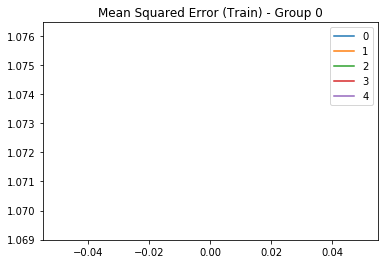

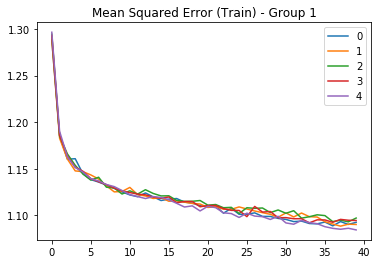

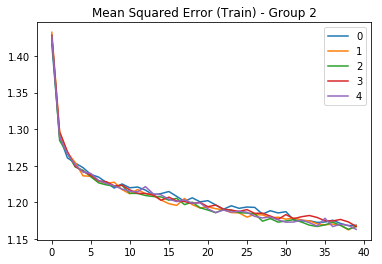

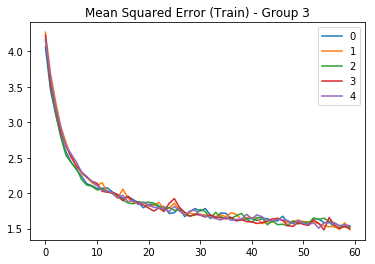

In [98]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['loss'], label=str(run))
        plt.title('Mean Squared Error (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

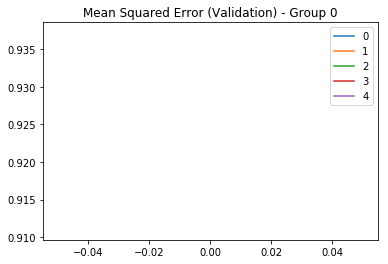

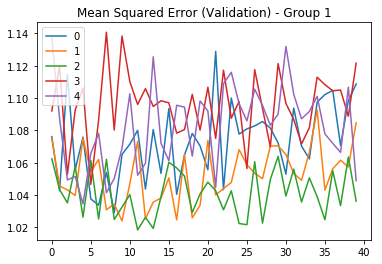

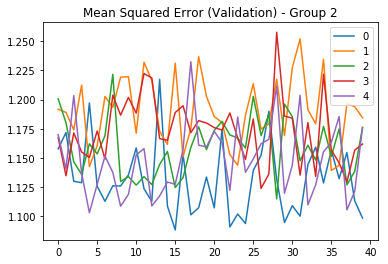

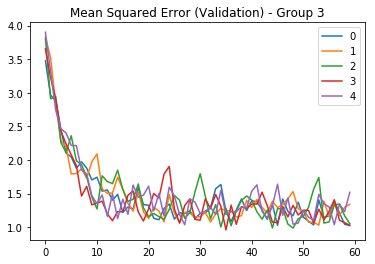

In [99]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_loss'], label=str(run))
        plt.title('Mean Squared Error (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

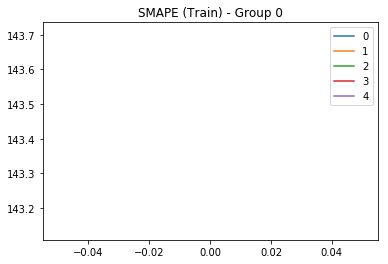

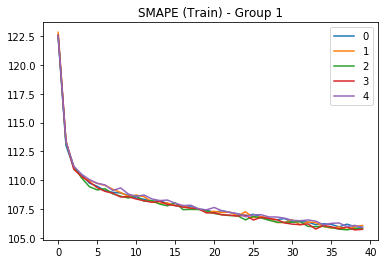

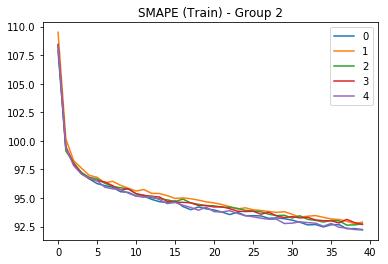

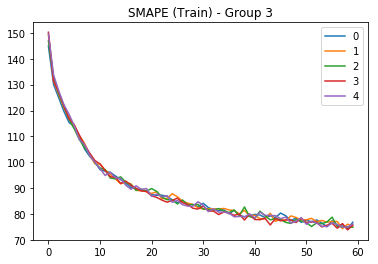

In [100]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['k_smape'], label=str(run))
        plt.title('SMAPE (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

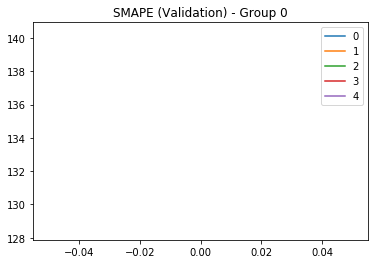

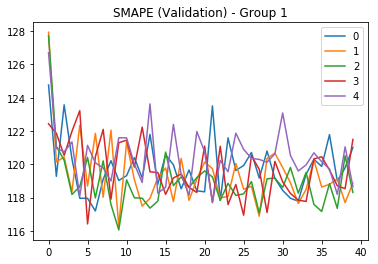

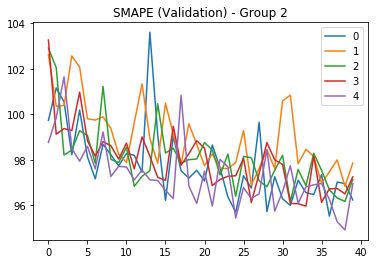

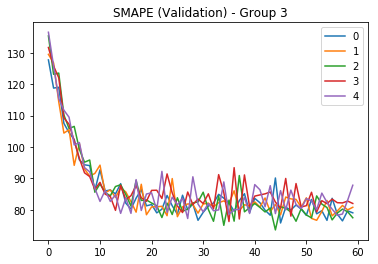

In [101]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_k_smape'], label=str(run))
        plt.title('SMAPE (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

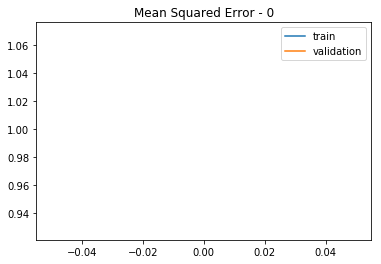

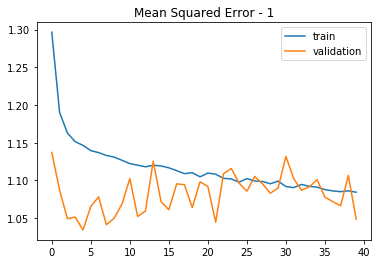

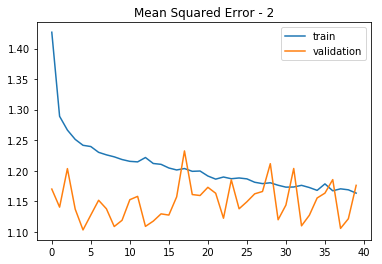

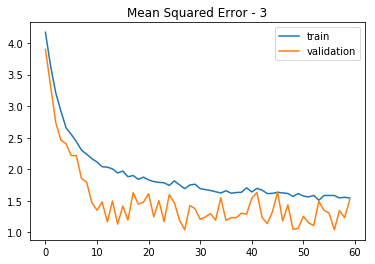

In [102]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

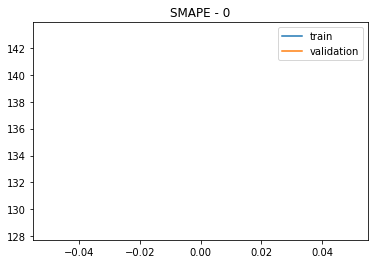

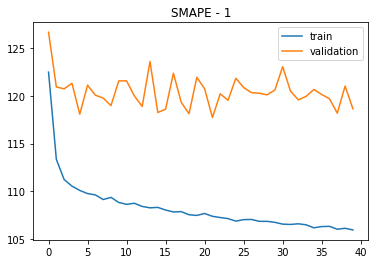

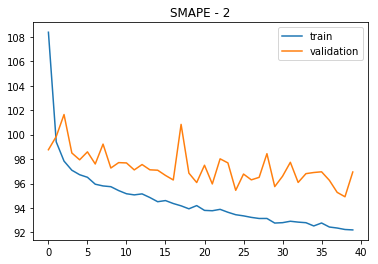

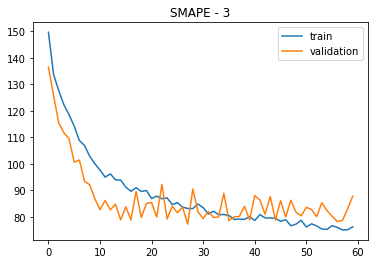

In [103]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

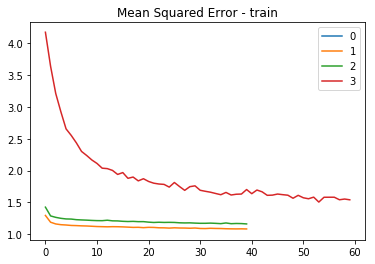

In [104]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

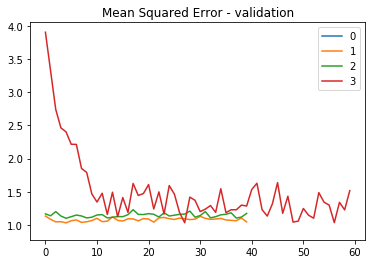

In [105]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

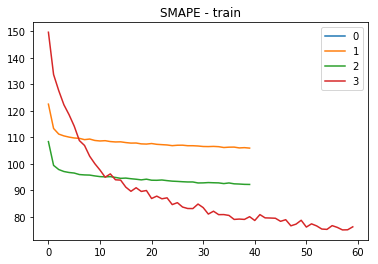

In [106]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

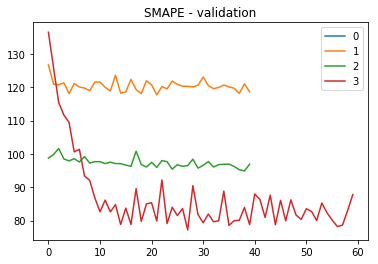

In [107]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

## Predict for Input Set (Training Set)

In [108]:
%%time
Y_input_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_input_pred_list = []
    for (gp, model, X, A) in zip(gp_list, models, X_input_list, A_input_list):
        print(gp, end=' ')
        Y_input_pred_list.append(model.predict([X, A]))
    Y_input_pred_list_ens.append(Y_input_pred_list)
    print('')

Run 0: 0 1 2 3 
Run 1: 0 1 2 3 
Run 2: 0 1 2 3 
Run 3: 0 1 2 3 
Run 4: 0 1 2 3 
Wall time: 57.3 s


%%time
Y_input_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_input_pred_list = []
    for (gp, model, X, A, Z) in zip(gp_list, models, X_input_list, A_input_list, Z_input_list):
        print(gp, end=' ')
        Y_input_pred_list.append(model.predict([X, A, Z]))
    Y_input_pred_list_ens.append(Y_input_pred_list)
    print('')

Find the original index

In [109]:
input_index_range = np.arange(len(input_gp)); #input_index_range

In [110]:
# list for original index
input_index_list = [input_index_range[input_gp == gp] 
                     for gp in gp_list]

In [111]:
for o in input_index_list:
    print(o.shape, end=' ')

(24379,) (41343,) (78354,) (987,) 

In [112]:
input_index_list_comb = np.concatenate(input_index_list); #input_index_list_comb

In [113]:
Y_input_pred_ens = []
for Y_input_pred_list in Y_input_pred_list_ens:
    Y_input_pred_comb = np.concatenate(Y_input_pred_list)
    Y_input_pred = [0]*len(input_index_list_comb)

    for index, y in zip(input_index_list_comb, Y_input_pred_comb):
        Y_input_pred[index] = y

    Y_input_pred = np.array(Y_input_pred)  # make it an numpy array (which will also make a copy)
    Y_input_pred_ens.append(Y_input_pred)

del Y_input_pred_comb

In [114]:
# Inverse transform Y_input_pred to original Y
Y_input_pred_ori_ens = []
for Y_input_pred in Y_input_pred_ens:
    Y_input_pred_ori = unlog(untransform(Y_input_pred, 
                                          Y_input_center, Y_input_scale))
    Y_input_pred_ori_ens.append(Y_input_pred_ori)

In [115]:
Y_input_pred_ori_ens = np.array(Y_input_pred_ori_ens)

## Predict for Output Set

In [116]:
%%time
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X, A) in zip(gp_list, models, X_output_list, A_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict([X, A]))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Run 0: 0 1 2 3 
Run 1: 0 1 2 3 
Run 2: 0 1 2 3 
Run 3: 0 1 2 3 
Run 4: 0 1 2 3 
Wall time: 49.4 s


%%time
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X, A, Z) in zip(gp_list, models, X_output_list, A_output_list, Z_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict([X, A, Z]))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Find the original index

In [117]:
output_index_range = np.arange(len(output_gp)); #output_index_range

In [118]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [119]:
for o in output_index_list:
    print(o.shape, end=' ')

(24379,) (41343,) (78354,) (987,) 

In [120]:
output_index_list_comb = np.concatenate(output_index_list); #output_index_list_comb

In [121]:
Y_output_pred_ens = []
for Y_output_pred_list in Y_output_pred_list_ens:
    Y_output_pred_comb = np.concatenate(Y_output_pred_list)
    Y_output_pred = [0]*len(output_index_list_comb)

    for index, y in zip(output_index_list_comb, Y_output_pred_comb):
        Y_output_pred[index] = y

    Y_output_pred = np.array(Y_output_pred)  # make it an numpy array (which will also make a copy)
    Y_output_pred_ens.append(Y_output_pred)

del Y_output_pred_comb

In [122]:
# Inverse transform Y_output_pred to original Y
Y_output_pred_ori_ens = []
for Y_output_pred in Y_output_pred_ens:
    Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                          Y_output_center, Y_output_scale))
    Y_output_pred_ori_ens.append(Y_output_pred_ori)

In [123]:
Y_output_pred_ori_ens = np.array(Y_output_pred_ori_ens)

#### Check predict output

Y_output_pred

Y_output_pred_ori

examine(Y_output_pred)

examine(Y_output_pred_ori)

view(X_output_ori[126420])

## SMAPE Scores

### Model Score

In [125]:
# SMAPE scores for the model
if test_length:
    model_smape_ens = []
    model_smape_0_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        model_smape = smape(Y_output_raw, Y_output_pred_ori) # SMAPE score excluding nan (Correct one)
        model_smape_0 = smape(Y_output_ori, Y_output_pred_ori) # SMAPE assuming nan == 0
        
        model_smape_ens.append(model_smape)
        model_smape_0_ens.append(model_smape_0)
    model_smape_ens_mean = np.mean(model_smape_ens)
    model_smape_0_ens_mean = np.mean(model_smape_0_ens)
    
    model_smape_stdev = np.std(model_smape_ens)  # standard deviation of the smape score
    model_smape_0_stdev = np.std(model_smape_0_ens)  # standard deviation of the smape score
    
    model_smape_ens_mean_std = model_smape_stdev / np.sqrt(len(model_smape_ens))

In [124]:
esmape = smape

In [126]:
# Estimated SMAPE scores for the model
model_esmape_ens = []
model_esmape_0_ens = []
for Y_input_pred_ori in Y_input_pred_ori_ens:
    model_esmape = esmape(Y_input_raw, Y_input_pred_ori) # SMAPE score excluding nan (Correct one)
    model_esmape_0 = esmape(Y_input_ori, Y_input_pred_ori) # SMAPE assuming nan == 0

    model_esmape_ens.append(model_esmape)
    model_esmape_0_ens.append(model_esmape_0)
model_esmape_ens_mean = np.mean(model_esmape_ens)
model_esmape_0_ens_mean = np.mean(model_esmape_0_ens)

model_esmape_stdev = np.std(model_esmape_ens)  # standard deviation of the esmape score
model_esmape_0_stdev = np.std(model_esmape_0_ens)  # standard deviation of the esmape score

model_esmape_ens_mean_std = model_esmape_stdev / np.sqrt(len(model_esmape_ens))

In [127]:
if test_length:
    for model_smape, model_smape_0 in zip(model_smape_ens, model_smape_0_ens):
        print('%6.3f' % model_smape, '       ', '%6.3f' % model_smape_0)
    print('-----------------------------')
    print('%6.3f' % model_smape_ens_mean, '+-%5.3f' % model_smape_stdev, 
          '%6.3f' % model_smape_0_ens_mean, '+-%5.3f' % model_smape_0_stdev)
    print('+-%5.3f' % model_smape_ens_mean_std)

In [128]:
for model_esmape, model_esmape_0 in zip(model_esmape_ens, model_esmape_0_ens):
    print('%6.3f' % model_esmape, '       ', '%6.3f' % model_esmape_0)
print('-----------------------------')
print('%6.3f' % model_esmape_ens_mean, '+-%5.3f' % model_esmape_stdev, 
      '%6.3f' % model_esmape_0_ens_mean, '+-%5.3f' % model_esmape_0_stdev)
print('+-%5.3f' % model_esmape_ens_mean_std)

41.517         54.075
42.327         54.331
41.930         54.659
42.052         55.166
41.845         54.864
-----------------------------
41.934 +-0.265 54.619 +-0.385
+-0.118


In [129]:
# SMAPE score for Fibonacci median
if test_length:
    fib_smape = smape(Y_output_raw, Y_output_fib)
    print(fib_smape)

In [130]:
# Estimated SMAPE score for Fibonacci median
fib_esmape = esmape(Y_input_raw, Y_input_fib)
print(fib_esmape)

47.0307


### Group Scores

In [131]:
# Prediction Y_output in group
Y_output_pred_ori_list_ens = [[Y_output_pred_ori[output_gp == gp] for gp in gp_list]
                              for Y_output_pred_ori in Y_output_pred_ori_ens]
#Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_list = Y_output_pred_ori_list_ens[-1]  # in case you want to see one of them

In [132]:
# Prediction Y_input in group
Y_input_pred_ori_list_ens = [[Y_input_pred_ori[input_gp == gp] for gp in gp_list]
                              for Y_input_pred_ori in Y_input_pred_ori_ens]
#Y_input_pred_ori_list = [Y_input_pred_ori[input_gp == gp] for gp in gp_list]
Y_input_pred_ori_list = Y_input_pred_ori_list_ens[-1]  # in case you want to see one of them

In [133]:
# Fibonacci median in group
Y_output_fib_list = [Y_output_fib[output_gp == gp] for gp in gp_list]

In [134]:
# Fibonacci median in group
Y_input_fib_list = [Y_input_fib[input_gp == gp] for gp in gp_list]

In [135]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [136]:
# True Y_input in group
# untransformed Y_input with nan replaced by 0
Y_input_ori_list = [Y_input_ori[input_gp == gp] for gp in gp_list]

# untransformed Y_input_ori with nan (for SMAPE estimation)
Y_input_raw_list = [Y_input_raw[input_gp == gp] for gp in gp_list]

In [137]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [138]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

if test_length: print(count_not_nan(Y_output_raw))

In [139]:
# Group scores for the model
if test_length:
    gp_output_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape_ens = [[smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list)]
                    for Y_output_pred_ori_list in Y_output_pred_ori_list_ens]
    gp_smape = gp_smape_ens[-1]    

In [140]:
# Estimated Group scores for the model
gp_input_n = [len(Y) for Y in Y_input_raw_list]
# SMAPE with nan values ignored (used by Kaggle)
gp_esmape_ens = [[esmape(Y, Y_p) for Y, Y_p in zip(Y_input_raw_list, Y_input_pred_ori_list)]
                for Y_input_pred_ori_list in Y_input_pred_ori_list_ens]
gp_esmape = gp_esmape_ens[-1]    

In [141]:
if test_length:
    gp_smape_mean = np.mean(gp_smape_ens, axis=0); print(gp_smape_mean)

In [142]:
gp_esmape_mean = np.mean(gp_esmape_ens, axis=0); gp_esmape_mean

array([ 68.06611633,  43.79360199,  34.40761948,  30.60266495], dtype=float32)

if test_length:
    #gp_smape = [smape(Y, Y_p) for Y, Y_p 
    #            in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    #n_not_nan = count_not_nan(Y_output_raw)
    #n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    #n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
    #                      in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    #gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    #gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

In [143]:
# Group score for Fibonacci median
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]

In [144]:
# Estimated Group score for Fibonacci median
gp_esmape_fib = [esmape(Y, Y_p) for Y, Y_p in zip(Y_input_raw_list, Y_input_fib_list)]

In [145]:
if test_length:  # gp_score compare
    print('#### ' + model_name)
    print('', end='|')
    print('N_pages ', 'Fibonacci', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_output_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|  Total ', ' %7.3f ' % fib_smape, ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

In [147]:
# Estimated gp_score compare
print('#### ' + model_name)
print('', end='|')
print('N_pages ', 'Fibonacci', ' Average ', sep='|', end='|')
for run in ens_list: print(' Model', run, end=' |')
print('')
print('', end='|')
print('--------', '---------', '---------', sep='|', end='|')
for run in ens_list: print('---------', end='|')
print('')
for gp in gp_list:
    print('', end='|')
    print(' %6d ' % gp_input_n[gp], end='|')
    print(' %7.3f ' % gp_esmape_fib[gp], end='|')
    print(' %7.3f ' % gp_esmape_mean[gp], end='|')
    for run in ens_list:
        print(' %7.3f ' % gp_esmape_ens[run][gp], end='|')
    print('')
print('|  Total ', ' %7.3f ' % fib_esmape, ' %7.3f ' % model_esmape_ens_mean, sep='|', end='|')
for run in ens_list:
        print(' %7.3f ' % model_esmape_ens[run], end='|')

#### model_10_Modified_CNN_4_The_Model_1_stage_1_predict
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  24379 |  62.502 |  68.066 |  67.361 |  69.361 |  67.754 |  68.396 |  67.458 |
|  41343 |  48.981 |  43.794 |  43.936 |  43.563 |  43.740 |  44.197 |  43.532 |
|  78354 |  42.138 |  34.408 |  33.781 |  34.887 |  34.528 |  34.345 |  34.497 |
|    987 |  39.764 |  30.603 |  29.454 |  31.654 |  28.978 |  28.761 |  34.166 |
|  Total |  47.031 |  41.934 |  41.517 |  42.327 |  41.930 |  42.052 |  41.845 |

#### model_10_Modified_CNN_4_The_Model
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.291 |  68.432 |  67.965 |  68.039 |  68.527 |  68.492 |
|  43691 |  40.612 |  39.986 |  39.863 |  39.935 |  40.101 |  39.696 |  40.336 |
|  75617 |  34.284 |  29.633 |  29.641 |  29.453 |  29.630 |  29.832 |  29.606 |
|    791 |  34.653 |  33.308 |  33.714 |  33.951 |  32.934 |  33.296 |  32.647 |
|  Total |  40.404 |  38.836 |  38.826 |  38.677 |  38.829 |  38.889 |  38.957 |
#### model_10_Modified_CNN_1_Z
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 158.876 | 166.920 | 167.117 | 154.478 | 165.189 | 140.678 |
|  23085 |  61.354 |  64.057 |  63.166 |  63.533 |  63.921 |  64.384 |  65.282 |
|  43691 |  40.612 |  40.025 |  40.088 |  39.890 |  40.224 |  40.132 |  39.794 |
|  75617 |  34.284 |  29.755 |  29.759 |  29.741 |  29.658 |  29.865 |  29.752 |
|    740 |  35.621 |  33.983 |  33.411 |  33.945 |  34.447 |  34.013 |  34.100 |
|     51 |  20.224 |  17.259 |  17.687 |  17.204 |  17.227 |  17.300 |  16.878 |
|  Total |  40.404 |  38.937 |  38.881 |  38.869 |  38.897 |  39.122 |  38.914 |
#### model_10_Modified_CNN_0_median_stdev_2_3_groups
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.900 |  69.367 |  69.103 |  69.194 |  69.001 |  67.833 |
|  43691 |  40.612 |  40.247 |  39.939 |  40.098 |  40.056 |  40.701 |  40.443 |
|  76408 |  34.288 |  29.910 |  29.979 |  30.039 |  29.790 |  29.676 |  30.068 |
|  Total |  40.404 |  39.140 |  39.154 |  39.194 |  39.062 |  39.169 |  39.119 |
#### model_10_Modified_CNN_0_median_stdev
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |
#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

#### model_9_CNN_with_Fibonacci_4_Ensemble
|N_pages |Fibonacci| Model 0 |
|--------|---------|---------|
|   1879 |  57.385 | 146.145 |
|  23085 |  61.354 |  64.128 |
|  43691 |  40.612 |  40.052 |
|  75617 |  34.284 |  29.862 |
|    740 |  35.621 |  34.607 |
|     51 |  20.224 |  16.023 |

if test_length:
    print('[Group SMAPE]')
    print('W/ Nan, Nan=0, Contribution, Pages, Non-nan Ratio')
    for score, score_0, c, n, nr in zip(gp_smape, gp_smape_0,
                                    gp_smape_cont, gp_output_n, 
                                    n_not_nan_ratio_gp):
        print('%6.2f' % score, '%6.2f' % score_0, '       %6.2f' % c, '%6d' % n,
              '        %6.3f' % nr)
    print('-------------------------------------------------')
    print('%6.2f' % model_smape, '%6.2f' % model_smape_0)

### Page Scores

In [149]:
if test_length:  # Page scores for the model
    smape_Y_pred_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        smape_Y_pred = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                               in zip(Y_output_pred_ori, Y_output_raw)]))
        smape_Y_pred_ens.append(smape_Y_pred)

In [148]:
# Estimated Page scores for the model
esmape_Y_pred_ens = []
for Y_input_pred_ori in Y_input_pred_ori_ens:
    esmape_Y_pred = np.nan_to_num(np.array([esmape(yp, y) for yp, y 
                                           in zip(Y_input_pred_ori, Y_input_raw)]))
    esmape_Y_pred_ens.append(esmape_Y_pred)

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [ ]:
if test_length:  # Page score for Fib.
    smape_Y_fib = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                          in zip(Y_output_fib, Y_output_raw)]))

In [150]:
# Estimated Page score for Fib.
esmape_Y_fib = np.nan_to_num(np.array([esmape(yp, y) for yp, y 
                                      in zip(Y_input_fib, Y_input_raw)]))

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


if test_length:
    for smape_Y_pred in smape_Y_pred_ens:
        plt.hist(smape_Y_pred, bins=40, alpha=0.4)
        #plt.yscale('log')
    plt.title('Ensemble Page SMAPE'); plt.show()

In [ ]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6, label='Fib.')
    plt.hist(smape_Y_pred, bins=40, alpha=0.6, label='Model')
    #plt.yscale('log')
    plt.legend(); plt.show()

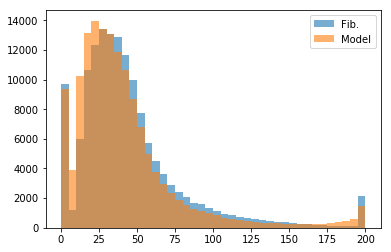

In [151]:
if test_length == 0:
    plt.hist(esmape_Y_fib, bins=40, alpha=0.6, label='Fib.')
    plt.hist(esmape_Y_pred, bins=40, alpha=0.6, label='Model')
    #plt.yscale('log')
    plt.legend(); plt.show()

### Page Scores in Each Group

In [152]:
if test_length:  # The model
    smape_Y_pred_list_ens = []
    for smape_Y_pred in smape_Y_pred_ens:
        smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]
        smape_Y_pred_list_ens.append(smape_Y_pred_list)

In [ ]:
if test_length == 0:  # The model
    esmape_Y_pred_list_ens = []
    for esmape_Y_pred in esmape_Y_pred_ens:
        esmape_Y_pred_list = [esmape_Y_pred[input_gp == gp] for gp in gp_list]
        esmape_Y_pred_list_ens.append(esmape_Y_pred_list)

In [153]:
if test_length:  # Fib.
    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]

#### Plots

In [154]:
if test_length:
    for gp,s in zip(gp_list,smape_Y_pred_list):
        plt.hist(s, bins=40, normed=True, alpha=0.6, label='gp = ' + str(gp))
    #plt.yscale('log')
    plt.legend(); plt.show()

In [155]:
if test_length:
    for gp,s in zip(gp_list,smape_Y_pred_list):
        plt.hist(s, bins=40, alpha=0.6, label='gp = ' + str(gp))
    #plt.yscale('log')
    plt.legend(); plt.show()

In [156]:
if test_length:
    for gp in gp_list:
        plt.hist(smape_Y_fib_list[gp], bins=40, alpha=0.6, label='Fib.')
        plt.hist(smape_Y_pred_list[gp], bins=40, alpha=0.6, label='Model')
        plt.title('gp = '+str(gp)); plt.legend()
        plt.show()
    #plt.yscale('log')
    #plt.ylim([0,0.05])

## Prediction Pre Combine
Combine group 0, 1 from Fib and rest from the model

Y_output_fib.shape

In [157]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 63)

In [158]:
Y_input_fib_ori = np.repeat(Y_input_fib, y_length, axis=1); Y_input_fib_ori.shape

(145063, 63)

In [159]:
# Select group 0 from Fib.
fib_mask = (output_gp == 0).reshape(-1,1); fib_mask.shape
#fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [160]:
# The combined result
Y_output_fmc_ori_ens = []
for Y_output_pred_ori in Y_output_pred_ori_ens:
    
    Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
    
    Y_output_fmc_ori_ens.append(Y_output_fmc_ori)

In [161]:
# The combined result for input set
Y_input_fmc_ori_ens = []
for Y_input_pred_ori in Y_input_pred_ori_ens:
    
    Y_input_fmc_ori = fib_mask * Y_input_fib_ori + (~fib_mask) * Y_input_pred_ori
    
    Y_input_fmc_ori_ens.append(Y_input_fmc_ori)

Y_output_fmc_ori

#### Pre Combined Score

In [163]:
if test_length: 
    fmc_smape_ens = []
    for Y_output_fmc_ori in Y_output_fmc_ori_ens:
        fmc_smape = smape(Y_output_fmc_ori, Y_output_raw)
        fmc_smape_ens.append(fmc_smape)        
    fmc_smape_ens_mean = np.mean(fmc_smape_ens)

In [162]:
fmc_esmape_ens = []
for Y_input_fmc_ori in Y_input_fmc_ori_ens:
    fmc_esmape = esmape(Y_input_fmc_ori, Y_input_raw)
    fmc_esmape_ens.append(fmc_esmape)        
fmc_esmape_ens_mean = np.mean(fmc_esmape_ens)

In [164]:
if test_length: 
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

In [166]:
for run, fmc_esmape, model_esmape in zip(ens_list, fmc_esmape_ens, model_esmape_ens):
    print('%6.3f' % fmc_esmape, '(%6.3f)' % model_esmape, '-', model_name, 'Est', run)
print('%6.3f' % fmc_esmape_ens_mean, '(%6.3f)' % model_esmape_ens_mean, '-', model_name, 'Est', 'Average')

40.821 (41.517) - model_10_Modified_CNN_4_The_Model_1_stage_1_predict Est 0
41.345 (42.327) - model_10_Modified_CNN_4_The_Model_1_stage_1_predict Est 1
41.178 (41.930) - model_10_Modified_CNN_4_The_Model_1_stage_1_predict Est 2
41.208 (42.052) - model_10_Modified_CNN_4_The_Model_1_stage_1_predict Est 3
41.136 (41.845) - model_10_Modified_CNN_4_The_Model_1_stage_1_predict Est 4
41.138 (41.934) - model_10_Modified_CNN_4_The_Model_1_stage_1_predict Est Average


## Ensemble Learning

### Ensemble Median

In [167]:
Y_output_pred_ori_ens_med = np.median(Y_output_pred_ori_ens, axis=0)
Y_output_pred_ori_ens_med.shape

(145063, 63)

In [168]:
Y_input_pred_ori_ens_med = np.median(Y_input_pred_ori_ens, axis=0)
Y_input_pred_ori_ens_med.shape

(145063, 63)

Y_output_pred_ori_ens_med

In [171]:
if test_length:
    ens_med_smape = smape(Y_output_pred_ori_ens_med, Y_output_raw); print(ens_med_smape)

In [170]:
ens_med_esmape = esmape(Y_input_pred_ori_ens_med, Y_input_raw); print(ens_med_esmape)

41.6015


Best ways seem to be taking median either before or after transformation.

### Ensemble Combine with Fibonacci Median

In [172]:
#Replace group 0 by Fib. Median
fib_mask = ((output_gp == 0)).reshape(-1,1); fib_mask.shape
#fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [173]:
Y_output_f_omed  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_med

In [174]:
Y_input_f_omed  = fib_mask * Y_input_fib_ori + (~fib_mask) * Y_input_pred_ori_ens_med

## All Model Scores

In [175]:
if test_length:  # Ensemble learning model score
    f_omed_smape = smape(Y_output_raw, Y_output_f_omed)

In [176]:
# Ensemble learning model score
f_omed_esmape = esmape(Y_input_raw, Y_input_f_omed)

In [179]:
if test_length: # The_score with (without) combining Fibonacci median model
    print('%6.3f' % f_omed_smape, '(%6.3f)' % ens_med_smape,'-', model_name, 'ori_ensemble_median')
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)

In [178]:
# The Estimated score with (without) combining Fibonacci median model
print('%6.3f' % f_omed_esmape, '(%6.3f)' % ens_med_esmape,'-', model_name, 'Est', 'ori_ensemble_median')
print('%6.3f' % fmc_esmape_ens_mean, '(%6.3f)' % model_esmape_ens_mean, '-', model_name, 'Est', 'Average')
for run, fmc_esmape, model_esmape in zip(ens_list, fmc_esmape_ens, model_esmape_ens):
    print('%6.3f' % fmc_esmape, '(%6.3f)' % model_esmape, '-', model_name, 'Est', run)

40.828 (41.601) - model_10_Modified_CNN_4_The_Model_1_stage_1_predict Est ori_ensemble_median
41.138 (41.934) - model_10_Modified_CNN_4_The_Model_1_stage_1_predict Est Average
40.821 (41.517) - model_10_Modified_CNN_4_The_Model_1_stage_1_predict Est 0
41.345 (42.327) - model_10_Modified_CNN_4_The_Model_1_stage_1_predict Est 1
41.178 (41.930) - model_10_Modified_CNN_4_The_Model_1_stage_1_predict Est 2
41.208 (42.052) - model_10_Modified_CNN_4_The_Model_1_stage_1_predict Est 3
41.136 (41.845) - model_10_Modified_CNN_4_The_Model_1_stage_1_predict Est 4


42.464 (43.447) - model_10_Modified_CNN_4_The_Model_1_stage_1_train ori_ensemble_median
42.755 (43.679) - model_10_Modified_CNN_4_The_Model_1_stage_1_train Average
42.677 (43.658) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 0
42.749 (43.744) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 1
42.754 (43.827) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 2
42.852 (43.521) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 3
42.745 (43.643) - model_10_Modified_CNN_4_The_Model_1_stage_1_train 4

37.429 (38.536) - model_10_Modified_CNN_4_The_Model ori_ensemble_median
37.731 (38.836) - model_10_Modified_CNN_4_The_Model Average
37.699 (38.826) - model_10_Modified_CNN_4_The_Model 0
37.623 (38.677) - model_10_Modified_CNN_4_The_Model 1
37.763 (38.829) - model_10_Modified_CNN_4_The_Model 2
37.748 (38.889) - model_10_Modified_CNN_4_The_Model 3
37.821 (38.957) - model_10_Modified_CNN_4_The_Model 4

37.436          - model_10_Modified_CNN_0_median_stdev ori_ens_mean
37.382          - model_10_Modified_CNN_0_median_stdev ori_ens_med
37.394          - model_10_Modified_CNN_0_median_stdev ens_mean_ori
37.382          - model_10_Modified_CNN_0_median_stdev ens_med_ori
37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average

Ensemble of model are all better than the individual model.

fmc_smape_ens

fmc_smape_ens_mean

 Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]

#### Stage 2 Scores:
37.473          - model_10_Modified_CNN_1_Z ori_ensemble_median

37.535          - model_10_Modified_CNN_0_median_stdev_2_3_groups ori_ensemble_median

37.382          - model_10_Modified_CNN_0_median_stdev ori_ens_med

37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average

38.734 (39.415) - Model 9.1.0 - model_9_CNN_with_Fibonacci_1_no_group 1

38.227 (39.321) - Model 9.0.0 - model_9_CNN_with_Fibonacci_0_separate_Fib_median 1

#### Stage 1 Scores:
42.464 (43.447) - model_10_Modified_CNN_4_The_Model_1_stage_1_train ori_ensemble_median

43.009 (44.180) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 2

44.070 (45.335) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 1

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 1

44.433 - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial

44.168 - Model 7.2.0

## All Group Scores

In [180]:
# ensemble result Y_output in each group
Y_output_pred_ori_ens_med_list = [Y_output_pred_ori_ens_med[output_gp == gp] for gp in gp_list]

In [181]:
# ensemble result Y_input in each group
Y_input_pred_ori_ens_med_list = [Y_input_pred_ori_ens_med[input_gp == gp] for gp in gp_list]

In [182]:
# Group SMAPE scores
if test_length:
    # SMAPE with nan values ignored (used by Kaggle)
    gp_omed_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_ens_med_list)]

In [183]:
# Group Estimated SMAPE scores
gp_omed_esmape = [esmape(Y, Y_p) for Y, Y_p in zip(Y_input_raw_list, Y_input_pred_ori_ens_med_list)]

In [ ]:
if test_length:  # The_gp_score
    print('#### ' + model_name)
    print('', end='|')
    print(' N_pages', 'Fibonacci', 'Ens Media', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_output_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
          ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

In [185]:
# The Estimated gp score
print('#### ' + model_name, 'Estimated')
print('', end='|')
print(' N_pages', 'Fibonacci', 'Ens Media', ' Average ', sep='|', end='|')
for run in ens_list: print(' Model', run, end=' |')
print('')
print('', end='|')
print('--------', '---------', '---------', '---------', sep='|', end='|')
for run in ens_list: print('---------', end='|')
print('')
for gp in gp_list:
    print('', end='|')
    print(' %6d ' % gp_input_n[gp], end='|')
    print(' %7.3f ' % gp_esmape_fib[gp], end='|')
    print(' %7.3f ' % gp_omed_esmape[gp], end='|')
    print(' %7.3f ' % gp_esmape_mean[gp], end='|')
    for run in ens_list:
        print(' %7.3f ' % gp_esmape_ens[run][gp], end='|')
    print('')
print('|Over All', ' %7.3f ' % fib_esmape, ' %7.3f ' % f_omed_esmape,
      ' %7.3f ' % model_esmape_ens_mean, sep='|', end='|')
for run in ens_list:
        print(' %7.3f ' % model_esmape_ens[run], end='|')

# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

#### model_10_Modified_CNN_4_The_Model_1_stage_1_predict Estimated
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  24379 |  62.502 |  67.908 |  68.066 |  67.361 |  69.361 |  67.754 |  68.396 |  67.458 |
|  41343 |  48.981 |  43.380 |  43.794 |  43.936 |  43.563 |  43.740 |  44.197 |  43.532 |
|  78354 |  42.138 |  34.087 |  34.408 |  33.781 |  34.887 |  34.528 |  34.345 |  34.497 |
|    987 |  39.764 |  29.091 |  30.603 |  29.454 |  31.654 |  28.978 |  28.761 |  34.166 |
|Over All|  47.031 |  40.828 |  41.934 |  41.517 |  42.327 |  41.930 |  42.052 |  41.845 |

#### model_10_Modified_CNN_4_The_Model
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.304 |  68.291 |  68.432 |  67.965 |  68.039 |  68.527 |  68.492 |
|  43691 |  40.612 |  39.627 |  39.986 |  39.863 |  39.935 |  40.101 |  39.696 |  40.336 |
|  75617 |  34.284 |  29.275 |  29.633 |  29.641 |  29.453 |  29.630 |  29.832 |  29.606 |
|    791 |  34.653 |  33.112 |  33.308 |  33.714 |  33.951 |  32.934 |  33.296 |  32.647 |
|Over All|  40.404 |  37.429 |  38.836 |  38.826 |  38.677 |  38.829 |  38.889 |  38.957 |
#### model_10_Modified_CNN_0_median_stdev_2_3_groups
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.909 |  68.900 |  69.367 |  69.103 |  69.194 |  69.001 |  67.833 |
|  43691 |  40.612 |  39.821 |  40.247 |  39.939 |  40.098 |  40.056 |  40.701 |  40.443 |
|  76408 |  34.288 |  29.400 |  29.910 |  29.979 |  30.039 |  29.790 |  29.676 |  30.068 |
|Over All|  40.404 |  37.535 |  39.140 |  39.154 |  39.194 |  39.062 |  39.169 |  39.119 |
#### model_10_Modified_CNN_0_median_stdev
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.741 | 172.496 | 191.624 | 172.496 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.110 |  64.122 |  64.116 |  64.122 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.620 |  39.564 |  39.574 |  39.564 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.300 |  29.231 |  29.248 |  29.231 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.403 |  33.482 |  33.373 |  33.482 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.360 |  16.338 |  16.361 |  16.338 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |
#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.921 | 173.799 | 189.346 | 173.799 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  63.635 |  63.651 |  63.644 |  63.651 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  39.693 |  39.628 |  39.637 |  39.628 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  29.444 |  29.368 |  29.381 |  29.368 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.858 |  33.893 |  33.837 |  33.893 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.861 |  16.948 |  16.856 |  16.948 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

## More Explore

## Optimize Group Models

### Group Models in other Groups

In [186]:
%%time
Y_output_all_ori_list_ens = unlog(np.array([[untransform(model.predict([X_output, A_output]), 
                                                         Y_output_center, output_scale) 
                                            for model in models] for models in models_ens]))
#Take 4 min on PC and NB

Wall time: 3min 24s


In [189]:
%%time
if test_length == 0:
    Y_input_all_ori_list_ens = unlog(np.array([[untransform(model.predict([X_input, A_input]), 
                                                         Y_input_center, input_scale) 
                                            for model in models] for models in models_ens]))
#Take 4 min on PC and NB

Wall time: 3min 27s


In [187]:
Y_output_all_ori_list_ens.shape  # (Ensemble, Group model, Y, y)

(5, 4, 145063, 63)

In [188]:
#Take Ensemble median
Y_output_all_ori_list_ens_med = np.median(Y_output_all_ori_list_ens, axis=0); Y_output_all_ori_list_ens_med.shape

(4, 145063, 63)

In [190]:
#Take Ensemble median for input set for estimation
if test_length == 0:
    Y_input_all_ori_list_ens_med = np.median(Y_input_all_ori_list_ens, axis=0); Y_input_all_ori_list_ens_med.shape

In [191]:
#Group scores for each group models
#row index: group model; column index: group of Y
if test_length:
    smape_gpm_gp_ens_med = [[smape(Y, Y_p[output_gp == gp]) for gp, Y in zip(gp_list, Y_output_raw_list)] 
                            for Y_p in Y_output_all_ori_list_ens_med]

In [193]:
#Group Est. scores for each group models
#row index: group model; column index: group of Y
if test_length == 0:
    esmape_gpm_gp_ens_med = [[esmape(Y, Y_p[input_gp == gp]) for gp, Y in zip(gp_list, Y_input_raw_list)] 
                            for Y_p in Y_input_all_ori_list_ens_med]

%%time
smape_gpm_gp_ens = []
for run in ens_list:
    print('Run', run)
    models = models_ens[run]
    Y_output_all_ori_list = unlog(np.array([untransform(model.predict([X_output, A_output]), 
                                                        Y_output_center, output_scale) 
                                            for model in models]))
    # row: model of the group; column: group of Y
    smape_gpm_gp = [[smape(Y, Y_p[output_gp == gp]) for gp, Y in zip(gp_list, Y_output_raw_list)] 
                    for Y_p in Y_output_all_ori_list]
    smape_gpm_gp_ens.append(smape_gpm_gp)
smape_gpm_gp_ens = np.array(smape_gpm_gp_ens)

smape_gpm_gp_mean = np.mean(smape_gpm_gp_ens, axis=0)

In [194]:
if test_length:
    print('Ens. Median   ', end='|')
    for j in range(len(smape_gpm_gp_ens_med[0])): print(' group', j, end='|')
    print('')
    print('--------------', end='|')
    for j in range(len(smape_gpm_gp_ens_med[0])): print('--------', end='|')
    print('')
    for i in range(len(smape_gpm_gp_ens_med)):
        print('group model', i, end=' |')
        for j in range(len(smape_gpm_gp_ens_med[0])):
            print(' %6.2f ' % smape_gpm_gp_ens_med[i][j], end='|')
        print('')
else:
    print('Ens. Median   ', end='|')
    for j in range(len(esmape_gpm_gp_ens_med[0])): print(' group', j, end='|')
    print('')
    print('--------------', end='|')
    for j in range(len(esmape_gpm_gp_ens_med[0])): print('--------', end='|')
    print('')
    for i in range(len(esmape_gpm_gp_ens_med)):
        print('group model', i, end=' |')
        for j in range(len(esmape_gpm_gp_ens_med[0])):
            print(' %6.2f ' % esmape_gpm_gp_ens_med[i][j], end='|')
        print('')

Ens. Median   | group 0| group 1| group 2| group 3|
--------------|--------|--------|--------|--------|
group model 0 |  67.91 |  48.15 |  42.37 |  39.40 |
group model 1 |  66.08 |  43.38 |  38.63 |  42.43 |
group model 2 |  67.18 |  46.10 |  34.09 |  35.66 |
group model 3 |  74.23 |  51.66 |  41.44 |  29.09 |


Only group model 2 and 3 are useful

In [196]:
if test_length: 
    for x in gp_omed_smape: print(' %6.2f ' % x, end='|')
else: 
    for x in gp_omed_esmape: print(' %6.2f ' % x, end='|')

  67.91 |  43.38 |  34.09 |  29.09 |

In [197]:
if test_length: 
    for x in gp_smape_fib: print(' %6.2f ' % x, end='|')
else: 
    for x in gp_esmape_fib: print(' %6.2f ' % x, end='|')

  62.50 |  48.98 |  42.14 |  39.76 |

Group 4 is better at group 3 model. Group 5 is better at group 2 or 3 model

### Optimized Group Models

In [201]:
if test_length:
    gpm_list = np.argmin(smape_gpm_gp_mean,axis=0)
else:
    gpm_list = np.array([0,1,2,2])

print(model_name,'gpm_list = [', end='')
for x in gpm_list: print(x, end=',')
print(']')

model_10_Modified_CNN_4_The_Model_1_stage_1_predict gpm_list = [0,1,2,2,]


In [202]:
gpm_mask = np.array([gpm_list == gp for gp in gp_list]).T; gpm_mask

array([[ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False,  True, False]], dtype=bool)

In [203]:
Y_output_ori_list_ens_med_temp = np.tensordot(gpm_mask, Y_output_all_ori_list_ens_med, axes=([1],[0]))

In [204]:
gp_mask = np.array([output_gp == gp for gp in gp_list]); gp_mask

array([[False, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [205]:
gp_mask_reshape = gp_mask.reshape(len(gp_mask),len(gp_mask[0]),1); gp_mask_reshape.shape

(4, 145063, 1)

In [206]:
Y_output_ori_list_ens_med_temp_mask = gp_mask_reshape * Y_output_ori_list_ens_med_temp

In [207]:
Y_output_ori_list_ens_med_temp_mask.shape

(4, 145063, 63)

In [208]:
Y_output_gpm_ens_med = np.sum(Y_output_ori_list_ens_med_temp_mask, axis=0)

In [209]:
Y_output_gpm_ens_med.shape

(145063, 63)

In [211]:
if test_length: gpm_ens_smape = smape(Y_output_raw, Y_output_gpm_ens_med)

In [212]:
if test_length: print(gpm_ens_smape, ens_med_smape)

#### Group scores

In [213]:
Y_output_gpm_ens_med_list = [Y_output_gpm_ens_med[output_gp == gp] for gp in gp_list]

In [214]:
# Group SMAPE scores
if test_length:
    gp_gpm_ens_med_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_gpm_ens_med_list)]

In [215]:
if test_length:
    #print('#### ' + model_name + 'group model optimized')
    #print('', end='|')
    print(' N_pages', 'Fibonacci', 'GPM Optim', 'Ens Media', ' Average ', sep='|', end='|')
    #or run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', '---------', sep='|', end='|')
    #for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_output_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_gpm_ens_med_smape[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        print('')
    #print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
    #      ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')    
# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

Group 0 of GPM Optimized is worse than Fib. Only the last group is improved.

#### Combined with Fib.

In [216]:
#Select group 0
#fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape
fib_mask = (output_gp == 0).reshape(-1,1); fib_mask.shape

(145063, 1)

In [217]:
Y_output_f_gpm = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_gpm_ens_med  # Our final output

In [218]:
if test_length: f_gpm_ens_smape = smape(Y_output_raw, Y_output_f_gpm)
if test_length: print('%6.3f' % f_gpm_ens_smape, '(%6.3f)' % gpm_ens_smape, '-', model_name, 'GPM Optim Ens')

## Plots

### Group model examination

In [221]:
Y_output_all_ori_list_ens_med.shape

(4, 145063, 63)

#### Group = 3

In [ ]:
gp = 3
Y_list = Y_output_all_ori_list_ens_med[:, output_gp == gp]

In [ ]:
Y_list.shape

In [ ]:
view_list = np.sort(np.random.choice(len(Y_list[0]), 5, replace=False)); view_list

In [ ]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.legend()
    plt.show()    

In [ ]:
orinal_view_list = np.arange(len(output_gp))[output_gp == gp][view_list];
np.array([view_list, orinal_view_list])

In [ ]:
np.array([fib_input_median[orinal_view_list], fib_output_median[orinal_view_list]])

#### Group = 2

In [ ]:
gp = 2
Y_list = Y_output_all_ori_list_ens_med[:, output_gp == gp]

In [ ]:
Y_list.shape

In [ ]:
view_list = np.sort(np.random.choice(len(Y_list[0]), 5, replace=False)); view_list

In [ ]:
output_log_std_p = [1.]

In [ ]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.legend()
    plt.show()    

In [ ]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    plt.plot(Y_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.yscale('log')
    plt.legend(); plt.show()    

In [ ]:
orinal_view_list = np.arange(len(output_gp))[output_gp == gp][view_list];
np.array([view_list, orinal_view_list])

In [ ]:
np.array([fib_input_median[orinal_view_list], fib_output_median[orinal_view_list]])

#### Case 131296

In [ ]:
i = 131296

In [ ]:
multi_view((Y_output_ori[i],Y_output_pred_ori[i]))

### Cases study

In [ ]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

view_list = examine_list_gp((Y_output_ori,
                             Y_output_pred_ori_ens_mean, 
                             Y_output_pred_ori_ens_med,
                             Y_output_pred_ori_ens[-1], 
                             ), output_gp, view_list=view_list)

i = 93175
plt.plot(Y_output_ori[i], label='true')
plt.plot(Y_output_pred_ori_ens_mean[i], label='ens mean')
plt.plot(Y_output_pred_ori_ens_med[i], label='ens median')
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.plot(Y_output_pred_ens_med_ori[i], label='ens median before transf')
plt.plot(Y_output_pred_ori_ens[-1][i], label='run: 4')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

i = 93175
plt.plot(Y_output_ori[i], label='true')
for run in ens_list:
    plt.plot(Y_output_pred_ori_ens[run][i], label='run' + str(run))
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

In [ ]:
view_list = examine_list_gp((Y_output_pred_ori_ens[-1], 
                             Y_output_pred_ori_ens_med,
                             Y_output_f_gpm, 
                             Y_output_ori), output_gp, view_list=view_list)

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

In [ ]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

In [ ]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

view_list = examine_list_gp((Y_output_pred, X_output, Y_input), output_gp, view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output), view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), view_list=view_list)

if test_length:
    view_list = examine_list_gp((Y_output_pred, Y_output, X_output), output_gp,
                             view_list=view_list)

if test_length:
    view_list = examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
                             view_list=view_list)

view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]; view_list_smape

view_list_review = [score < model_smape for score in view_list_smape]; view_list_review

view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

#### Good cases

examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
             view_list=view_list_good)

#### Bad cases

examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori),output_gp,
             view_list=view_list_bad)

print(Y_output_center[view_list_good].reshape(-1))
print(Y_output_center[view_list_bad].reshape(-1))

print(output_scale[view_list_good].reshape(-1))
print(output_scale[view_list_bad].reshape(-1))

output_gp[view_list_good]

output_gp[view_list_bad]

#### Case 93175

i = 93175

multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))

smape(Y_output_pred_ori[i], Y_output_raw[i])

Y_input_center[i], Y_output_center[i], input_scale[i], output_scale[i]

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

### Good and bad cases

review_Y = np.array([score < model_smape for score in smape_Y_pred])
good_Y_index = np.arange(len(Y_output_pred))[review_Y]; #good_Y_index
bad_Y_index = np.arange(len(Y_output_pred))[~review_Y]; #bad_Y_index

good_input_scale = input_scale[good_Y_index]
good_output_scale = output_scale[good_Y_index]
bad_input_scale = input_scale[bad_Y_index]
bad_output_scale = output_scale[bad_Y_index]

good_Y_input_center = Y_input_center[good_Y_index]
good_Y_output_center = Y_output_center[good_Y_index]
bad_Y_input_center = Y_input_center[bad_Y_index]
bad_Y_output_center = Y_output_center[bad_Y_index]

examine_list_gp((Y_output_pred_ori[good_Y_index], Y_output_ori[good_Y_index], X_output_ori[good_Y_index]), output_gp[good_Y_index])

examine_list_gp((Y_output_pred_ori[bad_Y_index], Y_output_ori[bad_Y_index], X_output_ori[bad_Y_index]), output_gp[bad_Y_index])

good_output_scale.min(), good_output_scale.max()

bad_output_scale.min(), bad_output_scale.max()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(good_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='good input')
plt.hist(good_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='good output')
plt.hist(bad_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

Should we split the data into std > and < 1.7 ?

np.mean(good_output_scale), np.mean(good_input_scale)

np.mean(bad_output_scale), np.mean(bad_input_scale)

plt.figure(figsize=(12,4))
plt.hist(bad_input_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(output_scale, bins=40, alpha=0.6, label='output')
plt.hist(input_scale, bins=40, alpha=0.6, label='input')
plt.legend()
plt.show()

np.histogram(output_scale, bins=np.arange(0,1,0.05))

#### Median

plt.figure(figsize=(12,4))
plt.hist(good_Y_input_center, bins=100, range=(0,5), alpha=0.6, label='good input')
plt.hist(good_Y_output_center, bins=100, range=(0,5), alpha=0.6, label='good output')
plt.hist(bad_Y_input_center, bins=100, range=(0,5), alpha=0.6, label='bad input')
plt.hist(bad_Y_output_center, bins=100, range=(0,5), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

### stdev/median

output_factor_1 = (Y_output_center / output_scale).reshape(-1); output_factor_1

output_factor_1.min(), output_factor_1.max()

plt.hist(output_factor_1, bins=40, range=[0,50], alpha=0.6)
plt.show()

plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, Y_output_center, alpha=0.1, marker='.')
plt.ylim([-0.1,5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.ylim([0,0.5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(output_scale, Y_output_center, alpha=0.1, marker='.')
plt.ylim([0,4.5])
plt.xlim([0,0.6])
plt.show()

output_factor_2 = (output_scale / Y_output_center).reshape(-1); output_factor_2

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_2, alpha=0.1, marker='.')
plt.ylim([0,0.8])
#plt.xlim([0,0.6])
plt.show()

output_factor_3 = (output_scale / (Y_output_center + 0.01)).reshape(-1); output_factor_3

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_3, alpha=0.1, marker='.')
plt.ylim([0,4])
#plt.xlim([0,0.6])
plt.show()

output_factor_4 = output_scale - input_scale

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_4, alpha=0.1, marker='.')
plt.ylim([-1.5,0.5])
#plt.xlim([0,0.6])
plt.show()

### Free some memory

In [224]:
del Y_input_pred
del Y_input_pred_ori
del Y_input_pred_ori_ens
del Y_input_pred_ori_ens_med
del Y_input_fib_ori
del Y_input_fmc_ori
del Y_input_f_omed
del Y_input_all_ori_list_ens
del Y_input_all_ori_list_ens_med
gc.collect()

In [225]:
%whos ndarray

Variable                              Type       Data/Info
----------------------------------------------------------
A                                     ndarray    987x2: 1974 elems, type `float32`, 7896 bytes
A_in                                  ndarray    987x2: 1974 elems, type `float32`, 7896 bytes
A_input                               ndarray    145063x2: 290126 elems, type `float32`, 1160504 bytes (1.1067428588867188 Mb)
A_output                              ndarray    145063x2: 290126 elems, type `float32`, 1160504 bytes (1.1067428588867188 Mb)
X                                     ndarray    987x63: 62181 elems, type `float32`, 248724 bytes (242.89453125 kb)
X_in                                  ndarray    987x63: 62181 elems, type `float32`, 248724 bytes (242.89453125 kb)
X_input                               ndarray    145063x63: 9138969 elems, type `float32`, 36555876 bytes (34.86240005493164 Mb)
X_input_center                        ndarray    145063x1: 145063 elems, ty

## Output Prediction
For predicting stage only

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [226]:
Y_output_dates

Index(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
       '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
       '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-14', '2017-01-15',
       '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24', '2017-01-25',
       '2017-01-26', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
       '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03', '2017-02-04',
       '2017-02-05', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
       '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13', '2017-02-14',
       '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-18', '2017-02-19',
       '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24',
       '2017-02-25', '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
       '2017-03-02', '2017-03-03', '2017-03-04'],
      dtype='object')

In [227]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_f_gpm, columns = Y_output_dates)  # using ensemble median combined result
result_df

,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2017-02-23,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-04
0,24.580452,24.958250,25.252094,26.379770,25.240250,25.256577,24.523016,26.434122,26.333342,25.158936,...,24.265806,23.355198,24.634209,26.186653,26.662029,24.019238,23.790018,23.442745,23.293545,24.563114
1,19.988680,19.444256,19.662882,20.947250,20.141594,20.186937,20.071405,21.967346,20.775558,19.791645,...,21.252411,20.537579,21.333490,22.922226,24.287184,21.502823,20.890442,20.740978,21.239527,22.113470
2,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
3,17.585825,17.842825,17.825588,18.718580,18.205399,18.198229,17.563759,18.521746,18.447372,17.814425,...,18.293797,17.631924,18.085138,19.185801,20.095474,18.097191,17.830334,17.762625,17.793238,18.229683
4,11.379908,11.774530,11.877324,12.398149,11.826940,11.770021,11.225264,12.209694,12.318961,11.527338,...,11.116136,10.745778,11.058803,12.161044,12.576981,11.129256,10.928871,10.878380,11.006664,11.374319
5,23.512836,23.437458,23.482603,24.056707,23.311903,23.291685,23.044331,24.783545,24.714987,23.157831,...,23.244822,22.902325,24.192705,26.285604,26.092112,23.569172,23.309261,22.725430,23.240044,24.669153
6,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,...,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000
7,52.326317,50.287651,50.038723,52.677567,49.568027,50.816948,52.345333,56.980385,53.049988,49.416389,...,49.861671,48.968163,55.795471,62.038841,56.662754,49.537308,48.597683,47.403702,49.814713,56.693340
8,45.415886,40.951828,40.454025,41.644524,39.745174,40.437153,43.814404,47.720871,41.950436,39.211628,...,40.820770,40.697617,45.594406,50.009342,44.957447,40.500145,39.816311,39.924301,40.740032,46.326397
9,31.948200,35.903172,37.017502,38.020878,37.531551,36.481998,32.352592,33.591869,37.724312,37.916393,...,35.574974,33.823448,31.304695,32.809864,36.284122,35.312157,34.706146,35.314548,34.052250,31.282269


In [228]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-04,Page
0,24.580452,24.958250,25.252094,26.379770,25.240250,25.256577,24.523016,26.434122,26.333342,25.158936,...,23.355198,24.634209,26.186653,26.662029,24.019238,23.790018,23.442745,23.293545,24.563114,2NE1_zh.wikipedia.org_all-access_spider
1,19.988680,19.444256,19.662882,20.947250,20.141594,20.186937,20.071405,21.967346,20.775558,19.791645,...,20.537579,21.333490,22.922226,24.287184,21.502823,20.890442,20.740978,21.239527,22.113470,2PM_zh.wikipedia.org_all-access_spider
2,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3C_zh.wikipedia.org_all-access_spider
3,17.585825,17.842825,17.825588,18.718580,18.205399,18.198229,17.563759,18.521746,18.447372,17.814425,...,17.631924,18.085138,19.185801,20.095474,18.097191,17.830334,17.762625,17.793238,18.229683,4minute_zh.wikipedia.org_all-access_spider
4,11.379908,11.774530,11.877324,12.398149,11.826940,11.770021,11.225264,12.209694,12.318961,11.527338,...,10.745778,11.058803,12.161044,12.576981,11.129256,10.928871,10.878380,11.006664,11.374319,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...
5,23.512836,23.437458,23.482603,24.056707,23.311903,23.291685,23.044331,24.783545,24.714987,23.157831,...,22.902325,24.192705,26.285604,26.092112,23.569172,23.309261,22.725430,23.240044,24.669153,5566_zh.wikipedia.org_all-access_spider
6,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,...,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,8.500000,91Days_zh.wikipedia.org_all-access_spider
7,52.326317,50.287651,50.038723,52.677567,49.568027,50.816948,52.345333,56.980385,53.049988,49.416389,...,48.968163,55.795471,62.038841,56.662754,49.537308,48.597683,47.403702,49.814713,56.693340,A'N'D_zh.wikipedia.org_all-access_spider
8,45.415886,40.951828,40.454025,41.644524,39.745174,40.437153,43.814404,47.720871,41.950436,39.211628,...,40.697617,45.594406,50.009342,44.957447,40.500145,39.816311,39.924301,40.740032,46.326397,AKB48_zh.wikipedia.org_all-access_spider
9,31.948200,35.903172,37.017502,38.020878,37.531551,36.481998,32.352592,33.591869,37.724312,37.916393,...,33.823448,31.304695,32.809864,36.284122,35.312157,34.706146,35.314548,34.052250,31.282269,ASCII_zh.wikipedia.org_all-access_spider


In [229]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

,Page,date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2017-01-01,24.580452
1,2PM_zh.wikipedia.org_all-access_spider,2017-01-01,19.988680
2,3C_zh.wikipedia.org_all-access_spider,2017-01-01,4.000000
3,4minute_zh.wikipedia.org_all-access_spider,2017-01-01,17.585825
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2017-01-01,11.379908
5,5566_zh.wikipedia.org_all-access_spider,2017-01-01,23.512836
6,91Days_zh.wikipedia.org_all-access_spider,2017-01-01,8.500000
7,A'N'D_zh.wikipedia.org_all-access_spider,2017-01-01,52.326317
8,AKB48_zh.wikipedia.org_all-access_spider,2017-01-01,45.415886
9,ASCII_zh.wikipedia.org_all-access_spider,2017-01-01,31.948200


In [230]:
del result_df

### Output DataFrame

In [232]:
if test_length == 0:
    print('%%% Reading data ', key_file, '...', end = '', flush = True)
    output_df = pd.read_csv('../data/' + key_file)
    print('done!')

%%% Reading data  key_1.csv ...done!


In [233]:
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

,Page,Id,date
0,!vote_en.wikipedia.org_all-access_all-agents,bf4edcf969af,2017-01-01
1,!vote_en.wikipedia.org_all-access_all-agents,929ed2bf52b9,2017-01-02
2,!vote_en.wikipedia.org_all-access_all-agents,ff29d0f51d5c,2017-01-03
3,!vote_en.wikipedia.org_all-access_all-agents,e98873359be6,2017-01-04
4,!vote_en.wikipedia.org_all-access_all-agents,fa012434263a,2017-01-05


In [234]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8703780 entries, 0 to 8703779
Data columns (total 3 columns):
Page    object
Id      object
date    object
dtypes: object(3)
memory usage: 199.2+ MB


In [237]:
output_df['date'].values[0:64]  # Make sure the range is 60 days (see if the dates resume after 60)

array(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
       '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
       '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
       '2017-01-13', '2017-01-14', '2017-01-15', '2017-01-16',
       '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24',
       '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28',
       '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
       '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05',
       '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
       '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13',
       '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17',
       '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21',
       '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25',
       '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
       '2017-01-01', '2017-01-02', '2017-01-03', '2017-

In [236]:
Y_output_dates

Index(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
       '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
       '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-14', '2017-01-15',
       '2017-01-16', '2017-01-17', '2017-01-18', '2017-01-19', '2017-01-20',
       '2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24', '2017-01-25',
       '2017-01-26', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
       '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03', '2017-02-04',
       '2017-02-05', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09',
       '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13', '2017-02-14',
       '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-18', '2017-02-19',
       '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24',
       '2017-02-25', '2017-02-26', '2017-02-27', '2017-02-28', '2017-03-01',
       '2017-03-02', '2017-03-03', '2017-03-04'],
      dtype='object')

In [238]:
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

,Page,Id,date,Visits
0,!vote_en.wikipedia.org_all-access_all-agents,bf4edcf969af,2017-01-01,3.000000
1,!vote_en.wikipedia.org_all-access_all-agents,929ed2bf52b9,2017-01-02,3.000000
2,!vote_en.wikipedia.org_all-access_all-agents,ff29d0f51d5c,2017-01-03,3.000000
3,!vote_en.wikipedia.org_all-access_all-agents,e98873359be6,2017-01-04,3.000000
4,!vote_en.wikipedia.org_all-access_all-agents,fa012434263a,2017-01-05,3.000000
5,!vote_en.wikipedia.org_all-access_all-agents,48f1e93517a2,2017-01-06,3.000000
6,!vote_en.wikipedia.org_all-access_all-agents,5def418fcb36,2017-01-07,3.000000
7,!vote_en.wikipedia.org_all-access_all-agents,77bd08134351,2017-01-08,3.000000
8,!vote_en.wikipedia.org_all-access_all-agents,5889e6dbb16f,2017-01-09,3.000000
9,!vote_en.wikipedia.org_all-access_all-agents,5f21fef1d764,2017-01-10,3.000000


In [239]:
del result_flat_df

In [240]:
gc.collect()

202220

In [241]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

Series([], Name: Visits, dtype: float32)

In [ ]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [242]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                  + '.csv', index = False, 
                                  float_format='%.3f')
print('done!')

%%% Writing result for model_10_Modified_CNN_4_The_Model_1_stage_1_predict ...done!


[10.4.1] 42.983

Kaggle LB Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]

[7.2.0] 46.5 [Model 7.2.0 CNN Fibonacci and original combined]